In [1]:
import pandas as pd
import json
import re
import os
import anndata as ad

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from typing import Dict, Tuple
import json

def calculate_foldchange_pvalue(
    df: pd.DataFrame,
    cat_vars: Dict[str, str],
    cont_vars: Dict[str, str],
    max_pvalue: float = 0.05,
    adjust_p_values: bool = True,
) -> pd.DataFrame:
    """
    Calculate log10 fold change and Wilcoxon p-values for all combinations of categorical and continuous variables.

    NOTE: This function assumes that each cat_var has exactly two unique values for comparison and these are represented as 0 and 1.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the data.
        cat_vars (dict): Dictionary of categorical column names and their display labels.
        cont_vars (dict): Dictionary of continuous column names and their display labels.
        max_pvalue (float): Maximum p-value to display; higher p-values are set to NaN.

    Returns:
        pd.DataFrame: DataFrame with columns ['Categorical', 'Continuous', 'Log10_FC', 'p-value', 'num_samples'].
    """
    all_results = []
    counter = 0
    # Calculate statistics for each target variable
    for cat_col, cat_label in cat_vars.items():
        sub_results = []
        # Iterate over continuous variables
        for cont_col, cont_label in cont_vars.items():
            if cat_col in df.columns and cont_col in df.columns:

                # Filter out rows with NaN values in either column
                valid_df = df[[cat_col, cont_col]].dropna()

                # Get values for both target variables (categories)
                grouped = valid_df.groupby(cat_col)[cont_col].apply(list)

                if len(grouped) == 2:
                    counter += 1
                    group_zero, group_one = grouped.loc[0], grouped.loc[1]

                    # Sample sizes
                    num_zero = len(group_zero)
                    num_one = len(group_one)
                    num_samples = num_zero + num_one

                    # Calculate medians
                    median_zero = np.median(group_zero)
                    median_one = np.median(group_one)

                    # Calculate 25th and 75th percentiles
                    percentile_25_zero = np.percentile(group_zero, 25)
                    percentile_75_zero = np.percentile(group_zero, 75)
                    percentile_25_one = np.percentile(group_one, 25)
                    percentile_75_one = np.percentile(group_one, 75)
                    
                    # Avoid division by zero
                    if median_zero > 0 and median_one > 0:
                        log10_fc = np.log10(median_one / median_zero)
                    else:
                        print(f"Warning: Zero median encountered for {cat_label} vs {cont_label}. Setting log10 FC to NaN.")
                        log10_fc = np.nan

                    _, p_value = ranksums(group_zero, group_one)
                    
                    sub_results.append((cat_label, cont_label, log10_fc, p_value, median_zero, median_one, percentile_25_zero, percentile_75_zero, percentile_25_one, percentile_75_one, num_zero, num_one, num_samples, ))
                else:
                    pass
                    #print(f"Warning: Categorical column {cat_col} does not have exactly two groups for comparison. Got {len(grouped)} groups.")
            else:
                print(f"Warning: Columns {cat_col} or {cont_col} not found in DataFrame.")

        sub_results = pd.DataFrame(sub_results, columns=['Categorical', 'Continuous', 'Log10_FC', 'p-value', "median_0", "median_1", "percentile_25_0", "percentile_75_0", "percentile_25_1", "percentile_75_1", "num_0", "num_1", "num_samples"]) #.replace([np.inf, -np.inf], np.nan)
        
        # Adjust p-values for multiple testing        
        if adjust_p_values and len(sub_results) > 1:
            sub_results['p-value'] = multipletests(sub_results['p-value'], method='fdr_bh')[1]

        # Append to all results
        all_results.append(sub_results)
    
    # Combine all results into a single DataFrame
    results_df = pd.concat(all_results, ignore_index=True)

    # Sanity check for number of comparisons made
    assert counter == results_df.shape[0], "Mismatch in number of comparisons made and results recorded."
    
    return results_df


def plot_balloon_plot(
    df: pd.DataFrame,
    cat_vars: Dict[str, str],
    cont_vars: Dict[str, str],
    max_pvalue: float = 0.05,
    adjust_p_values: bool = True,
    plot_height: int = 3,
    plot_width: int = 3,
    fontsize: int = 7,
    title: str = None,
    sort_by_pvalue: bool = False,
    scale_factor: float | None = None,
    xlabel: str = "",
    ylabel: str = "",
    swap_axes: bool = False,
    cbar_divider: int = 6,
    save_path: str = None,
) -> None:
    """
    Creates a balloon plot where color encodes log10 fold-change and size encodes -log10(p-value)
    for categorical vs continuous variable combinations.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        cat_vars (Dict[str, str]): Mapping of categorical columns to display names.
        cont_vars (Dict[str, str]): Mapping of continuous columns to display names.
        max_pvalue (float): Maximum p-value threshold to plot.
        plot_height (int): Height of the plot in inches.
        plot_width (int): Width of the plot in inches.
        fontsize (int): Font size used in plot.
        title (str): Optional title for the plot.
        sort_by_pvalue (bool): Whether to sort the plot entries by p-value.
        save_path (str): Path to save the figure.
    """
    stats = calculate_foldchange_pvalue(df, cat_vars, cont_vars, max_pvalue, adjust_p_values)

    # Filter out non-significant results
    results_df = stats.copy()
    results_df.loc[results_df['p-value'] > max_pvalue, 'Log10_FC'] = np.nan
    results_df.loc[results_df['p-value'] > max_pvalue, 'p-value'] = np.nan

    # set p-values below < 0.001 to 0.001 for visualization purposes
    results_df.loc[results_df['p-value'] < 0.001, 'p-value'] = 0.001

    if sort_by_pvalue:
        results_df = results_df.sort_values(by="p-value", ascending=False)

    vmax = np.abs(results_df['Log10_FC']).max()
    results_df['log_p'] = -np.log10(results_df['p-value'])
    if scale_factor is None:
        scale_factor = min(plot_height, plot_width) + 1
    results_df['size_scaled'] = (scale_factor * results_df['log_p']) ** 2

    is_vertical = len(results_df["Categorical"].unique()) > 1
    x_col, y_col = ('Continuous', 'Categorical') if is_vertical else ('Categorical', 'Continuous')

    if swap_axes:
        x_col, y_col = y_col, x_col

    if not is_vertical:
        plot_width = 1

    # Make y_col categorical with a specified order
    desired_order = list(cont_vars.values())
    results_df[y_col] = pd.Categorical(results_df[y_col], categories=desired_order, ordered=True)

    # Map categories to numeric positions
    y_mapping = {label: i for i, label in enumerate(desired_order)}
    results_df['y_numeric'] = results_df[y_col].map(y_mapping)

    fig, ax = plt.subplots(figsize=(plot_width, plot_height))

    scatter = ax.scatter(
        results_df[x_col],
        results_df['y_numeric'],  # use numeric y-values
        c=results_df['Log10_FC'],
        s=results_df['size_scaled'],
        edgecolors="black",
        cmap='coolwarm',
        vmin=-vmax,
        vmax=vmax,
        alpha=1
    )

    # Set ticks and labels
    ax.set_yticks(range(len(desired_order)))
    ax.set_yticklabels(variable for variable in desired_order)

    # Axis labels and formatting
    plt.xticks(rotation=45 if is_vertical else 0, ha='right' if is_vertical else 'center', fontsize=fontsize - 1)
    plt.yticks(fontsize=fontsize - 1)

    # Padding for layout
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    padding = 0.6
    ax.set_ylim(ymin - padding, ymax + padding)
    ax.set_xlim(xmin - padding, xmax + padding)

    # Colorbar
    norm = plt.Normalize(-vmax, vmax)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("")
    cbar.ax.set_title(r"Log$_{10}$ FC", pad=10, fontsize=fontsize - 1, loc='left')
    cbar.ax.tick_params(labelsize=fontsize-1)

    # P-value legend (ball sizes)
    legend_p_values = [0.001, 0.01, 0.05]
    legend_elements = [
        Line2D([0], [0],
            marker='o',
            color='none',
            label=f'{p:.3f}' if p > 0.001 else '< 0.001',
            markerfacecolor='dimgrey',
            markersize=-scale_factor * np.log10(p),
            markeredgecolor="none")
        for p in legend_p_values
    ]

    ax.legend(
        handles=legend_elements,
        title=r"$\it{{P}}$-value",
        fontsize=fontsize - 1,
        loc='upper left',
        bbox_to_anchor=(1, 0.95),
        frameon=False,
        title_fontsize=fontsize - 1,
    )

    # Adjust colorbar position
    x0, y0, w, h = ax.get_position().bounds
    legend_x = x0 + w
    cbar.ax.set_position([legend_x + 0.05, 1 - y0 - h, 0.1, plot_height / cbar_divider])

    # Axis & title
    ax.set_xlabel(xlabel, fontsize=fontsize-1)
    ax.set_ylabel(ylabel, fontsize=fontsize-1)
    ax.set_axisbelow(True)
    ax.grid(axis='both', alpha=0.5, zorder=0)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.tick_params(left=False, bottom=False)

    if title:
        ax.set_title(title, fontsize=fontsize)

    #plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

    plt.show()

    stats['p-value'] = results_df['p-value'].round(3)
    stats['Log10_FC'] = results_df['Log10_FC'].round(3)
    stats['median_0'] = results_df['median_0'].round(3)
    stats['median_1'] = results_df['median_1'].round(3)
    stats['percentile_25_0'] = results_df['percentile_25_0'].round(3)
    stats['percentile_75_0'] = results_df['percentile_75_0'].round(3)
    stats['percentile_25_1'] = results_df['percentile_25_1'].round(3)
    stats['percentile_75_1'] = results_df['percentile_75_1'].round(3)
    stats.dropna(subset=['p-value', 'Log10_FC'], inplace=True)

    return stats, results_df

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Iterable, Callable, Optional


def create_cell_statistic_summary_matrix(
    df: pd.DataFrame,
    cell_types: Iterable[str],
    variable_order: Iterable[str],
    readable_variable_func: Callable[[str], str],
    pvalue_col: str = "p-value",
    categorical_col: str = "Categorical",
    continuous_col: str = "Continuous",
    max_p_value: float = 0.05,
) -> pd.DataFrame:
    """
    Create pivot matrix of significant associations.

    Returns matrix ready for heatmap plotting.
    """

    def _extract_cell_type(name: str, cell_types: Iterable[str]) -> Optional[str]:
        """Extract the first matching cell type from a string."""
        if pd.isna(name):
            return None
        for cell in cell_types:
            if cell in name:
                return cell
        return None

    df = df[[categorical_col, continuous_col, pvalue_col]].copy()

    # Determine significance
    df["significant"] = (
        df[pvalue_col].notna() &
        (df[pvalue_col] < max_p_value)
    )

    # Extract cell types
    df["cell_type"] = df[continuous_col].apply(
        lambda x: _extract_cell_type(x, cell_types)
    )

    # Remove unused columns
    df = df.drop(columns=[continuous_col, pvalue_col])

    # Aggregate
    summary = (
        df.groupby(["cell_type", categorical_col])
        .agg(
            total_associations=("significant", "count"),
            significant_associations=("significant", "sum"),
        )
        .reset_index()
    )

    # Pivot to matrix format
    matrix = summary.pivot(
        index="cell_type",
        columns=categorical_col,
        values="significant_associations",
    )

    # Sort rows using provided cell type order
    order_dict = {k: i for i, k in enumerate(cell_types)}
    matrix = matrix.sort_index(key=lambda x: x.map(order_dict))

    # Rename and reorder columns using provided variable order and readable names
    readable_vars = [readable_variable_func(v) for v in variable_order]

    return matrix[readable_vars]


def plot_cell_statistic_summary(
    matrix: pd.DataFrame,
    figsize: tuple = (4.5, 6),
    cmap: str = "Blues",
    cbar_label: str = "Number of significant associations",
    font_size: int = 8,
    cbar_shrink: float = 0.5,
    xtick_rotation: int = 45,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    title: Optional[str] = None,
) -> plt.Axes:
    """
    Plot heatmap with adjustable font sizes and centered half-height colorbar.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        matrix,
        cmap=cmap,
        ax=ax,
        cbar_kws={
            "shrink": cbar_shrink,
            #"aspect": 20
        },
        vmin=vmin,
        vmax=vmax,
    )

    # Colorbar formatting
    cbar = ax.collections[0].colorbar
    cbar.set_label(
        cbar_label,
        rotation=270,
        labelpad=15,
        fontsize=font_size-1,
    )
    cbar.ax.tick_params(labelsize=font_size-1)
    cbar.ax.set_anchor("C") # Center colorbar vertically

    ax.set_xlabel("", fontsize=font_size-1)
    ax.set_ylabel("", fontsize=font_size-1)
    ax.tick_params(axis="x", labelsize=font_size-1)
    ax.tick_params(axis="y", labelsize=font_size-1)
    ax.set_title(title, fontsize=font_size)

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=xtick_rotation,
        ha="right",
        fontsize=font_size-1,
    )
    #plt.tight_layout()

    return ax


In [55]:
import pandas as pd
import numpy as np
import scipy

from pandas.api.types import is_numeric_dtype as is_pandas_dtype_numeric

from statsmodels.stats.multitest import multipletests
from typing import List, Tuple, Dict, Union, Set, Optional


from typing import Set


def wilcoxon_rank_sum_test(
    data: pd.DataFrame,
    predicted_variable: str,
    variables: Optional[Union[List[str], str]] = None,
    keep: bool = False,
    max_p_value: float = 0.05,
    adjust_p_values: bool = False,
) -> pd.DataFrame:
    """
    Perform the Wilcoxon rank-sum test between a binary target variable and numerical features.

    Parameters:
        data (pd.DataFrame): DataFrame containing the dataset.
        predicted_variable (str): Binary target variable (e.g., bool, str like "yes"/"no", or 0/1).
        variables (Optional[List[str] | str]): Variables to include or exclude (see `keep`).
        keep (bool): Whether to include (`True`) or exclude (`False`) the specified variables.
        max_p_value (float): Max p-value threshold for filtering results.
        adjust_p_values (bool): Apply multiple testing correction using FDR if True.

    Returns:
        pd.DataFrame: Summary table with columns:
                      ['covariate', 'wilcoxon-statistic', 'p-value', 'number of samples']
    """
    if isinstance(variables, str):
        variables = [variables]
    elif variables is None:
        variables = data.drop(columns=predicted_variable).select_dtypes(include=['bool', 'object']).columns.tolist()

    # Select columns to use
    if keep:
        test_data = data[variables + [predicted_variable]].copy()
    else:
        test_data = data.drop(columns=variables).copy()

    # Normalize predicted variable into a boolean mask
    unique_vals = data[predicted_variable].dropna().unique()
    if len(unique_vals) != 2:
        raise ValueError(f"Expected binary variable with 2 unique values, got {len(unique_vals)}: {unique_vals}")

    val_true, val_false = unique_vals[0], unique_vals[1]
    test_data[predicted_variable] = test_data[predicted_variable] == val_true  # Convert to boolean mask

    results = {'covariate': [], 'wilcoxon-statistic': [], 'p-value': [], 'number of samples': []}

    for variable in test_data.columns:
        if variable == predicted_variable or not is_pandas_dtype_numeric(test_data[variable]):
            continue

        temp_data = test_data[[predicted_variable, variable]].dropna()
        if temp_data.empty:
            continue

        try:
            mask = temp_data[predicted_variable].to_numpy(dtype=bool)
            values = temp_data[variable].to_numpy()
            group1 = values[mask]
            group2 = values[~mask]

            if len(group1) == 0 or len(group2) == 0:
                continue

            result = scipy.stats.ranksums(group1, group2)
            results['covariate'].append(variable)
            results['wilcoxon-statistic'].append(result.statistic)
            results['p-value'].append(result.pvalue)
            results['number of samples'].append(len(temp_data))
        except Exception as e:
            print(f"Failed to test variable: {variable} ({e})")

    results_df = pd.DataFrame(results)

    if adjust_p_values and not results_df.empty:
        results_df['p-value'] = multipletests(results_df['p-value'], method='fdr_bh')[1]

    results_df = results_df.sort_values('p-value').round(3)
    return results_df[results_df['p-value'] <= max_p_value]


In [56]:
CELL_DIFF_VARIABLE_NAMES_BM = {
    # Blasts
    'Blasts_proportion': 'Blasts',
    # Erythropoiesis:
    'Proerythroblasts_proportion': 'Proerythroblasts',
    'Erythroblasts_proportion': 'Erythroblasts',
    'Megakaryocytes_proportion': 'Megakaryocytes',
    # Granulopoiesis:
    'Promyelocytes_proportion': 'Promyelocytes',
    'Myelocytes_proportion': 'Myelocytes',
    'Metamyelocytes_proportion': 'Metamyelocytes',
    'Basophils_proportion': 'Basophils',
    'Neutrophils_proportion': 'Neutrophils',
    'Eosinophils_immature_proportion': 'Immature eosinophils',
    'Eosinophils_proportion': 'Mature eosinophils',
    # Monocytopoiesis:
    'Promonocytes_proportion': 'Promonocytes',
    'Monocytes_proportion': 'Monocytes',
    #'Macrophages_proportion': 'Macrophages',
    # Lymphopoiesis:
    'Lymphocytes_proportion': 'Lymphocytes',
    'Plasma_cells_proportion': 'Plasma cells',
}

CELL_LINEAGE_ORDER_BM = [
    # Blasts
    'Blasts',
    # Erythropoiesis:
    'Proerythroblasts',
    'Erythroblasts',
    'Megakaryocytes',
    # Granulopoiesis:
    'Promyelocytes',
    'Myelocytes',
    'Metamyelocytes',
    'Basophils',
    'Neutrophils',
    'Eosinophils_immature',
    'Eosinophils',
    # Monocytopoiesis:
    'Promonocytes',
    'Monocytes',
    'Macrophages',
    # Lymphopoiesis:
    'Lymphocytes',
    'Plasma_cells',
]

CELL_STATISTIC_ORDER = [
    # size features
    "entire_area_median",
    "nucleus_area_median",
    "entire_N:C-ratio_median",
    # shape features
    "nucleus_solidity_median",
    "nucleus_eccentricity_median",
    "nucleus_compactness_median",
    "entire_compactness_median",   
]

CELL_DIFF_VARIABLE_NAMES_PB = {
    # Blasts
    "Blasts_proportion": "Blasts",
    # Erythropoiesis:
    "Erythroblasts_proportion": "Erythroblasts",
    # Platelets:
    #"Giant_platelets_proportion": "Giant platelets",
    #"Platelet_aggregations_proportion": "Platelet aggregations",
    # Granulopoiesis:
    "Myelocytes_proportion": "Myelocytes",
    "Metamyelocytes_proportion": "Metamyelocytes",
    "Basophils_proportion": "Basophils",
    "Band_neutrophils_proportion": "Band neutrophils",
    "Segmented_neutrophils_proportion": "Segmented neutrophils",
    "Eosinophils_proportion": "Eosinophils",
    # Monocytopoiesis:
    "Monocytes_proportion": "Monocytes",
    # Lymphopoiesis:
    "Lymphocytes_proportion": "Lymphocytes",
    "Plasma_cells_proportion": "Plasma cells",
    
}

CELL_LINEAGE_ORDER_PB = [
    # Blasts
    "Blasts",
    # Erythropoiesis:
    "Erythroblasts",
    # Platelets:
    "Giant_platelets",
    "Platelet_aggregations",
    # Granulopoiesis:
    "Myelocytes",
    "Metamyelocytes",
    "Basophils",
    "Band_neutrophils",
    "Segmented_neutrophils",
    "Eosinophils",
    # Monocytopoiesis:
    "Monocytes",
    # Lymphopoiesis:
    "Lymphocytes",
    "Plasma_cells",
]

CUSTOM_VARIABLES = {
    "TP53_OR_monosomy17_del_17p": "TP53 or monosomy 17 / del(17p)",
    "FLT3_ITD": "FLT3-ITD",
    "RTK_RAS_mutations": "RTK/RAS mutations",
    "IDH_mutations": "IDH mutations",
    "Spliceosome_mutations": "Spliceosome mutations",
    "RUNX1-RUNX1T1_OR_t_8_21": "RUNX1-RUNX1T1",
    "monosomy_del_5": "monosomy 5 / del(5q)",
    "monosomy7_del_7q": "monosomy 7 / del(7q)",
    "t_11": "trisomy 11",
}

In [57]:
def _extract_variable_from_folder(folder_name: str) -> str:
    """Extract the variable portion from a folder name."""
    RUN_PREFIX = "run_"
    FOLDER_SPLIT_DELIMITER = "_"
    FOLDER_VARIABLE_SPLIT_INDEX = 3  # extract everything after this index

    if RUN_PREFIX in folder_name:
        # Extract everything after the Nth underscore
        parts = folder_name.split(FOLDER_SPLIT_DELIMITER, FOLDER_VARIABLE_SPLIT_INDEX)
        return parts[-1]
    return folder_name


def split_label(text):
    """
    Split a long string into two lines near the middle.
    Returns the original string if no space is found.
    """
    if not text or " " not in text:
        return text
    
    mid = len(text) // 2
    # find nearest space to the midpoint
    left_space = text.rfind(" ", 0, mid)
    right_space = text.find(" ", mid)

    # choose the closer space
    if left_space == -1:
        split_pos = right_space
    elif right_space == -1:
        split_pos = left_space
    else:
        split_pos = left_space if (mid - left_space) < (right_space - mid) else right_space

    return text[:split_pos] + "\n" + text[split_pos+1:]


def extract_prediction_results(requested_variable, prediction_result_dir):

    for run_name in os.listdir(prediction_result_dir):
        run_dir = os.path.join(prediction_result_dir, run_name)
        variable_name = _extract_variable_from_folder(run_name)
        if variable_name == requested_variable:
            all_results = []
            for item in os.listdir(run_dir):
                sub_dir = os.path.join(run_dir, item)
                if os.path.isdir(sub_dir):
                    fold_num = int(sub_dir.split("_")[-1])
                    result_path = os.path.join(
                        sub_dir,
                        f"cell_attention_scores_fold={fold_num}.csv"
                    )
                    results = pd.read_csv(result_path)
                    results.drop_duplicates(subset="bag_id", inplace=True)
                    results = results[
                        ["album_id", "database_id", "true_label", "pred_label", "pred_prob"]
                    ]
                    all_results.append(results)

            df = pd.concat(all_results)

            # Ensure album_id is string
            df.album_id = df.album_id.astype(str)

            # Convert labels to boolean
            pred_positive = df["pred_label"].astype(bool)
            target_positive = df["true_label"].astype(bool)

            # Confusion matrix components
            df["true_positive"] = pred_positive & target_positive
            df["false_positive"] = pred_positive & ~target_positive
            df["true_negative"] = ~pred_positive & ~target_positive
            df["false_negative"] = ~pred_positive & target_positive

            df["pred_positive"] = pred_positive
            df["pred_negative"] = ~pred_positive
            df["target_positive"] = target_positive
            df["target_negative"] = ~target_positive

            return df

In [58]:
import os
import pandas as pd


CUSTOM_LABELS = {
    "TP53_OR_monosomy17_del_17p": "mutations",
}
LABEL_MAP = {
    "fusion genes": ("Fusion (-)", "Fusion (+)"),
    "cytogenetic abnormalities": ("Normal", "Abnormal"),
    "mutations": ("Wild-type", "Mutated"),
}

def get_label_group(target: str):
    # First check for manual overrides
    if target in CUSTOM_LABELS:
        return CUSTOM_LABELS[target]

    # Pattern-based rules
    t = target.lower()

    if "fusion" in t or "runx1-runx1" in t or "cbfb" in t or "pml-rara" in t:
        return "fusion genes"
    elif any(
        k in t for k in ["monosomy", "trisomy", "t_", "del_", "amp_", "dup_", "add_", "inv_"]
    ):
        return "cytogenetic abnormalities"
    elif "mutation" in t or "mutations" in t:
        return "mutations"
    else:
        # Default to generic mutation terminology for gene names
        return "mutations"


def collect_performance_metrics(base_dir: str, metric: str) -> pd.DataFrame:

    def _read_metric_values(df: pd.DataFrame, metric: str) -> tuple[float, float]:
        """Extract mean and std metric values from the DataFrame."""

        FOLD_COLUMN = "fold"
        FOLD_MEAN_LABEL = "mean"
        FOLD_STD_LABEL = "std"

        mean_val = df.loc[df[FOLD_COLUMN] == FOLD_MEAN_LABEL, metric].values[0]
        std_val = df.loc[df[FOLD_COLUMN] == FOLD_STD_LABEL, metric].values[0]
        return mean_val, std_val

    RESULT_FILE_NAME = "results.xlsx"

    records = []
    for root, _, files in os.walk(base_dir):
        if RESULT_FILE_NAME not in files:
            continue

        file_path = os.path.join(root, RESULT_FILE_NAME)

        df = pd.read_excel(file_path)

        mean_val, std_val = _read_metric_values(df, metric)

        folder_name = os.path.basename(root)
        variable = _extract_variable_from_folder(folder_name)
        group = get_label_group(variable)

        records.append({
            #"folder": folder_name,
            "variable": variable,
            "group": group,
            f"{metric}_mean": mean_val,
            f"{metric}_std": std_val,
        })

    result_df = pd.DataFrame(records)
    return result_df.sort_values("variable").reset_index(drop=True)


def collect_cell_attention_scores(
        base_dir: str,
        subset: str = "all",
        cell_label_order: list[str] = None,
    ) -> pd.DataFrame:
    """
    Collects mean cell type attention scores from all folders in base_dir.
    
    Parameters:
    - base_dir: root folder containing subfolders with cell_attention_summary.xlsx
    - cell_label_order: optional list specifying the desired order of cell_label columns
    
    Returns a DataFrame with rows as variables, columns as cell_labels, and
    values as mean_cell_type_attention_score_all.
    """

    ATTENTION_FILE_NAME = "cell_attention_summary.xlsx"
    records = []

    for root, _, files in os.walk(base_dir):
        if ATTENTION_FILE_NAME not in files:
            continue

        file_path = os.path.join(root, ATTENTION_FILE_NAME)
        df = pd.read_excel(file_path)

        folder_name = os.path.basename(root)
        variable = _extract_variable_from_folder(folder_name)
        group = get_label_group(variable)

        # Add variable and group columns
        df = df.copy()
        df["variable"] = variable
        df["group"] = group

        records.append(df[["variable", "group", "cell_label", f"mean_cell_type_attention_score_{subset}"]])

    if not records:
        return pd.DataFrame()  # return empty DataFrame if nothing was found

    combined_df = pd.concat(records, ignore_index=True)

    # Pivot table: rows=variable, columns=cell_label, values=mean_cell_type_attention_score_[subset]
    pivot_df = combined_df.pivot_table(
        index=["variable", "group"],
        columns="cell_label",
        values=f"mean_cell_type_attention_score_{subset}"
    ).reset_index()

    # Reorder cell_label columns if custom order provided
    if cell_label_order:
        # Keep variable and group columns at the front
        fixed_cols = ["variable", "group"]
        # Only include labels that exist in the pivot table
        existing_labels = [label for label in cell_label_order if label in pivot_df.columns]
        pivot_df = pivot_df[fixed_cols + existing_labels]

    # Optional: sort by variable
    pivot_df = pivot_df.sort_values("variable").reset_index(drop=True)

    return pivot_df


def collect_cell_type_importance(
        base_dir: str,
        subset: str = "true",
        cell_label_order: list[str] = None,
    ) -> pd.DataFrame:
    """
    Collects mean cell type attention scores from all folders in base_dir.
    
    Parameters:
    - base_dir: root folder containing subfolders with cell_attention_summary.xlsx
    - cell_label_order: optional list specifying the desired order of cell_label columns
    
    Returns a DataFrame with rows as variables, columns as cell_labels, and
    values as mean_cell_type_attention_score_all.
    """

    ATTENTION_FILE_NAME = "cell_attention_summary.xlsx"
    records = []
    records_pos = []
    records_neg = []

    for root, _, files in os.walk(base_dir):
        if ATTENTION_FILE_NAME not in files:
            continue

        file_path = os.path.join(root, ATTENTION_FILE_NAME)
        df = pd.read_excel(file_path)

        folder_name = os.path.basename(root)
        variable = _extract_variable_from_folder(folder_name)
        group = get_label_group(variable)

        # Add variable and group columns
        df = df.copy()
        df["variable"] = variable
        df["group"] = group
        df[f"cell_type_importance_{subset}"] = df[f"mean_cell_type_logit_{subset}_pos"] - df[f"mean_cell_type_logit_{subset}_neg"]

        records.append(df[["variable", "group", "cell_label", f"cell_type_importance_{subset}"]])
        records_pos.append(df[["variable", "group", "cell_label", f"mean_cell_type_logit_{subset}_pos"]])
        records_neg.append(df[["variable", "group", "cell_label", f"mean_cell_type_logit_{subset}_neg"]])

    if not records:
        return None  # return empty DataFrame if nothing was found

    combined_df = pd.concat(records, ignore_index=True)
    combined_pos_df = pd.concat(records_pos, ignore_index=True)
    combined_neg_df = pd.concat(records_neg, ignore_index=True)

    # Pivot table: rows=variable, columns=cell_label, values=cell_type_importance_[subset]
    pivot_df = combined_df.pivot_table(
        index=["variable", "group"],
        columns="cell_label",
        values=f"cell_type_importance_{subset}"
    ).reset_index()
    pivot_pos_df = combined_pos_df.pivot_table(
        index=["variable", "group"],
        columns="cell_label",
        values=f"mean_cell_type_logit_{subset}_pos"
    ).reset_index()
    pivot_neg_df = combined_neg_df.pivot_table(
        index=["variable", "group"],
        columns="cell_label",
        values=f"mean_cell_type_logit_{subset}_neg"
    ).reset_index()

    # Reorder cell_label columns if custom order provided
    if cell_label_order:
        # Keep variable and group columns at the front
        fixed_cols = ["variable", "group"]
        # Only include labels that exist in the pivot table
        existing_labels = [label for label in cell_label_order if label in pivot_df.columns]

        pivot_df = pivot_df[fixed_cols + existing_labels]
        pivot_pos_df = pivot_pos_df[fixed_cols + existing_labels]
        pivot_neg_df = pivot_neg_df[fixed_cols + existing_labels]

    # Optional: sort by variable
    pivot_df = pivot_df.sort_values("variable").reset_index(drop=True)
    pivot_pos_df = pivot_pos_df.sort_values("variable").reset_index(drop=True)
    pivot_neg_df = pivot_neg_df.sort_values("variable").reset_index(drop=True)

    return pivot_df, pivot_pos_df, pivot_neg_df


import matplotlib.pyplot as plt
import pandas as pd


def plot_metric_errorbars(
    df: pd.DataFrame,
    metric: str,
    *,
    # ---- Appearance / Layout ----
    font_size: int = 12,
    fig_width: float = 8.0,
    fig_min_height: float = 4.0,
    fig_height_per_row: float = 0.2,
    title: str = "",
    x_label: str | None = None,
    x_limit: tuple[float, float] | None = None,
    x_ticks: list[float] | None = None,
    disable_sorting: bool = False,

    # ---- Error Bar Settings ----
    error_line_width: float = 2.0,
    error_cap_size: float = 2.0,
    marker_size: float = 6.0,
    marker_alpha: float = 0.8,

    # ---- Colors / Legend ----
    group_colors: dict = None,
    legend_title: str = "Mutation Group",
    legend_loc: str = "upper left",
    legend_bbox: tuple = (1.02, 1),

    # ---- Other Axes Styling ----
    grid_style: str = "--",
    grid_alpha: float = 0.5,
):
    """
    Plot horizontal error bars showing mean ± std for a given metric.
    All styling and former constants can be overridden via arguments.
    """

    # Default colors (only if user doesn't override)
    if group_colors is None:
        group_colors = {
            "fusion genes": "tab:blue",
            "cytogenetic abnormalities": "tab:green",
            "mutations": "tab:orange",
        }

    # If no x-axis label given, auto-generate
    if x_label is None:
        x_label = f"{metric.upper()} (Mean ± STD)"

    if not disable_sorting:
        # Sort & prepare positions
        if "roc_auc_mean" in df.columns:
            df = df.sort_values([f"roc_auc_mean"], ascending=True).reset_index(drop=True)
        else:
            df = df.sort_values([f"{metric}_mean"], ascending=True).reset_index(drop=True)
    
    df["y_pos"] = range(len(df))

    # Dynamic figure height
    fig_height = max(fig_min_height, len(df) * fig_height_per_row)

    # Create figure
    plt.figure(figsize=(fig_width, fig_height))

    # Plot error bars
    for _, row in df.iterrows():
        plt.errorbar(
            x=row[f"{metric}_mean"],
            y=row["y_pos"],
            xerr=row[f"{metric}_std"],
            fmt="o",
            color=group_colors[row["group"]],
            ecolor="gray",
            elinewidth=error_line_width,
            capsize=error_cap_size,
            markersize=marker_size,
            alpha=marker_alpha,
        )

    # Y ticks: labels
    y_labels = df["variable"].apply(get_readable_variable_name)
    plt.yticks(df["y_pos"], y_labels, fontsize=font_size - 2)
    if x_ticks is not None:
        plt.xticks(x_ticks, fontsize=font_size - 2)
    else:
        plt.xticks(fontsize=font_size - 2)

    # First item at top
    plt.gca().invert_yaxis()

    # Tight x and y limits
    if x_limit is not None:
        plt.xlim(x_limit[0], x_limit[1])
    plt.ylim(-0.5, len(df) - 0.5)

    # Ax labels and title
    plt.xlabel(x_label, fontsize=font_size - 2)
    plt.title(title)

    # Legend
    for group, color in group_colors.items():
        plt.scatter([], [], color=color, label=group)
    plt.legend(title=legend_title, bbox_to_anchor=legend_bbox, loc=legend_loc)

    # Grid & axes cleanup
    plt.grid(axis="x", linestyle=grid_style, alpha=grid_alpha)
    ax = plt.gca()
    ax.spines[["right", "top", "left"]].set_visible(False)

    plt.tight_layout()
    plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cell_attention_heatmap(
    df: pd.DataFrame,
    *,
    cell_label_order: list[str] | None = None,
    cmap = "Blues",
    center: float | None = None,
    normalize: bool = True,
    figsize: tuple = (8, 10),
    annot: bool = False,
    fmt: str = ".2f",
    square: bool = True,
    linewidths: float = 0.8,
    cbar_shrink: float = 0.25,
    cbar_label: str = "Normalized \nattention score",
    cbar_pad: float = 0.15,
    title: str = "Cell type attention",
    return_ax: bool = False,
):
    """
    Plot a heatmap of cell-type attention scores.
    - df: rows = variables (index), columns = cell types
    - cell_label_order: optional list to order/filter columns
    - normalize: if True, normalize each row by its row max
    Returns the Axes if return_ax is True.
    """
    plot_df = df.copy()
    plot_df.index = plot_df.index.to_series().apply(get_readable_variable_name)

    # Reorder / filter columns if requested
    if cell_label_order:
        cols = [c for c in cell_label_order if c in plot_df.columns]
        plot_df = plot_df[cols]

    # Row-wise normalization
    if normalize:
        plot_df = plot_df.div(plot_df.max(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.heatmap(
        plot_df,
        cmap=cmap,
        annot=annot,
        fmt=fmt,
        square=square,
        center=center,
        linewidths=linewidths,
        cbar=True,
        cbar_kws={
            "shrink": cbar_shrink,
            "label": cbar_label,
            "orientation": "horizontal",
            "pad": cbar_pad,
        },
        ax=ax,
    )

    plt.xticks(rotation=45, ha="right")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, pad=15)
    plt.tight_layout()
    plt.show()

    if return_ax:
        return ax


In [59]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb


def get_label_ratio_table(df: pd.DataFrame) -> pd.DataFrame:
    """Summarize counts and ratios for 'POS', 'NEG' and NaN per column."""
    rows = []
    for col in df.columns:
        col_series = df[col]
        pos = int((col_series == "POS").sum())
        neg = int((col_series == "NEG").sum())
        nan = int(col_series.isna().sum())
        valid = pos + neg
        if valid == 0:
            continue
        rows.append(
            {
                "variable": col,
                "N": valid,
                "POS": pos,
                "NEG": neg,
                "NaN": nan,
                "POS_ratio": round(pos / valid, 3),
                "NEG_ratio": round(neg / valid, 3),
                "NaN_ratio": round(nan / (valid + nan), 3),
            }
        )
    return pd.DataFrame(rows)

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch
from typing import Optional, Dict, Tuple


def oncoprint(
    df: pd.DataFrame,
    category_colors: Dict[str, str],
    category_names: Optional[Dict[str, str]] = None,
    order_by: str = "POS",
    missing_label: str = "NaN",
    missing_color: str = "#C6C6C6",
    figsize=(10, 6),
    show_percentages: Optional[str] = None,
    order_samples: bool = True,
    order_features: bool = True,
    highlight_feature: Optional[str] = None,
    highlight_color: str = "tab:red",
    title: str = "OncoPrint",
    xlabel: str = "Samples",
    ylabel: str = "Features",
    fontsize: int = 8,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Generalized oncoprint supporting multiple categories (TP, FP, TN, FN, POS, NEG, etc.)

    category_colors:
        dict mapping category name -> color

    order_by:
        category used to order features and samples (default="POS")

    missing_label:
        label used for NaN values

    missing_color:
        color for missing values
    """

    # Replace NaN with explicit label
    cat_df = df.fillna(missing_label)

    categories = list(category_colors.keys())
    if missing_label not in categories:
        categories.append(missing_label)

    color_map = category_colors.copy()
    color_map[missing_label] = missing_color

    # Boolean matrix for ordering
    if isinstance(order_by, (list, tuple, set)):
        order_mat = cat_df.isin(order_by)
    else:
        order_mat = (cat_df == order_by)

    # Feature ordering
    if order_features:
        col_order = (
            order_mat.sum(axis=0)
            .sort_values(ascending=False)
            .index.tolist()
        )
    else:
        col_order = cat_df.columns.tolist()

    cat_df = cat_df[col_order[::-1]]
    order_mat = order_mat[col_order[::-1]]

    # Sample ordering
    if order_samples:
        ordered_idx = order_mat.sort_values(
            by=col_order, ascending=False
        ).index
        cat_df = cat_df.loc[ordered_idx]

    n_samples, n_features = cat_df.shape

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0)

    ax_heat = fig.add_subplot(gs[0, 0])
    ax_bar = fig.add_subplot(gs[0, 1])

    # Convert to RGB image
    matrix = cat_df.T.values

    img = np.zeros((n_features, n_samples, 3))

    for category, color in color_map.items():
        rgb = to_rgb(color)
        mask = matrix == category
        img[mask] = rgb

    # Highlight feature
    if highlight_feature in cat_df.columns:
        hf_idx = list(cat_df.columns).index(highlight_feature)
        rgb = to_rgb(highlight_color)
        img[hf_idx, :, :] = np.where(
            matrix[hf_idx, :, None] == order_by,
            rgb,
            img[hf_idx, :, :]
        )

    ax_heat.imshow(img, aspect="auto", interpolation="none", origin="upper")

    ax_heat.set_xlim(-0.5, n_samples - 0.5)
    ax_heat.set_ylim(-0.5, n_features - 0.5)
    ax_heat.set_xticks([])
    ax_heat.set_yticks(np.arange(n_features))
    ax_heat.set_yticklabels(cat_df.columns, fontsize=fontsize)

    ax_heat.set_xlabel(xlabel, fontsize=fontsize - 1)
    ax_heat.set_ylabel(ylabel, fontsize=fontsize - 1)
    ax_heat.set_title(title, fontsize=fontsize)

    ax_heat.tick_params(axis="y", length=0)

    for spine in ax_heat.spines.values():
        spine.set_visible(False)

    # ---- BARPLOT ----

    summary = (
        cat_df.apply(lambda col: col.value_counts())
        .fillna(0)
        .T
    )

    summary = summary.reindex(cat_df.columns)

    nan_counts = summary.get(missing_label, pd.Series(0, index=summary.index))
    valid_totals = summary.sum(axis=1) - nan_counts

    y_positions = np.arange(n_features)

    left = np.zeros(n_features)

    for category in categories:

        counts = summary.get(category, pd.Series(0, index=summary.index)).values

        colors = [color_map[category]] * n_features

        if category == order_by and highlight_feature in summary.index:
            hf_idx = summary.index.tolist().index(highlight_feature)
            colors[hf_idx] = highlight_color

        ax_bar.barh(
            y_positions,
            counts,
            left=left,
            color=colors,
            height=0.95,
        )

        left += counts

    total_max = left.max()

    ax_bar.set_xlim(0, total_max)
    ax_bar.set_ylim(ax_heat.get_ylim())

    ax_bar.set_yticks([])
    ax_bar.set_xlabel("Count", fontsize=fontsize - 1)

    xticks = range(0, int(total_max) + 1, max(1, int(total_max) // 4))
    ax_bar.set_xticks(xticks)
    ax_bar.set_xticklabels(xticks, fontsize=fontsize - 1)

    for spine in ax_bar.spines.values():
        spine.set_visible(False)

    ax_bar.spines["bottom"].set_visible(True)

    # Legend
    legend_elements = [
        Patch(facecolor=color_map[c], edgecolor="black", label=category_names.get(c, c) if category_names else c)
        for c in categories
    ]

    if highlight_feature is not None:
        legend_elements.append(
            Patch(facecolor=highlight_color, label="Highlighted")
        )

    ax_bar.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False,
        fontsize=fontsize - 1,
    )

    if show_percentages is not None and show_percentages in summary.columns:

        counts = summary[show_percentages].values

        # position of category segment = cumulative sum up to that category
        left_positions = np.zeros(n_features)

        for category in categories:
            if category == show_percentages:
                break
            left_positions += summary.get(category, 0).values

        offset = total_max * 0.01

        for i in range(n_features):

            count = counts[i]
            valid = valid_totals.iloc[i]

            if valid > 0 and count > 0:

                pct = count / valid * 100

                ax_bar.text(
                    left_positions[i] + count + offset,
                    i,
                    f"{pct:.0f}%",
                    va="center",
                    ha="left",
                    fontsize=max(6, fontsize - 2),
                    clip_on=False,
                )

    plt.show()


import pandas as pd
import numpy as np


def build_oncoprint_data_from_predictions(
    df: pd.DataFrame,
    mode: str,
    pred_suffix: str = "_predicted",
    pos_label: str = "POS",
    neg_label: str = "NEG",
) -> pd.DataFrame:
    """
    Build oncoprint dataframe in one of two modes.

    Parameters
    ----------
    mode : str

        "POS_FP_TN"
            POS = TP + FN
            FP  = FP
            TN  = TN

        "TP_FN_NEG"
            TP  = TP
            FN  = FN
            NEG = TN + FP
    """

    if mode not in ["POS_FP_TN", "TP_FN_NEG"]:
        raise ValueError("mode must be 'POS_FP_TN' or 'TP_FN_NEG'")

    result = {}

    for col in df.columns:

        if col.endswith(pred_suffix):
            continue

        pred_col = col + pred_suffix
        if pred_col not in df.columns:
            continue

        truth = df[col]
        pred = df[pred_col]

        out = pd.Series(index=df.index, dtype="object")

        nan_mask = truth.isna() | pred.isna()
        out[nan_mask] = np.nan

        TP = (truth == pos_label) & (pred == pos_label)
        FN = (truth == pos_label) & (pred == neg_label)
        FP = (truth == neg_label) & (pred == pos_label)
        TN = (truth == neg_label) & (pred == neg_label)

        if mode == "POS_FP_TN":

            out[truth == pos_label] = "POS"
            out[FP] = "FP"
            out[TN] = "TN"

        elif mode == "TP_FN_NEG":

            out[TP] = "TP"
            out[FN] = "FN"
            out[truth == neg_label] = "NEG"

        result[col] = out

    return pd.DataFrame(result, index=df.index)



In [61]:

def get_readable_variable_name(target: str):
    # First check for manual overrides
    if target in CUSTOM_VARIABLES:
        return CUSTOM_VARIABLES[target]
    t = target.replace("_OR_", " / ").replace("_AND_", " + ")
    return t


def get_target_labels(df, label_map, include_variables=None):

    # Reverse label map to map from column names to original labels
    label_map = {v: k for k, v in label_map.items()}

    if include_variables is None:
        include_variables = list(label_map.keys())

    df = df.rename(columns=label_map)
    df = df[["subject_id", "album_id", "database_id"] + include_variables]
    df.album_id = df.album_id.astype(str)

    return df

def get_dysplasia_variables(df):
    df = df.filter(regex=r"proportion")
    df = df.loc[:, ~df.columns.str.contains(
        # Exclusion criterias
        'Living_cells' # main cell differentials
        '|QUALITY_' # megakaryocyte quality proportions (not in PB but does not hurt to exclude)
        # types of cells not used in dysplasia
        '|Lymphocytes'
        '|Macrophages' # does not exist in PB but does not hurt to exclude
        '|Plasma_cells'
    )]
    return df.columns.to_list()


def get_cell_statistic_variables(df):
    df = df.filter(regex=
        # Cell features
        "entire_area_median" # cell size
        "|N:C-ratio_median" # N:C ratio
        "|entire_compactness_median" # cell shape irregularity
        # Nucleus features
        "|nucleus_area_median" # nucleus size
        "|nucleus_solidity_median" # nucleus banding
        "|nucleus_eccentricity_median" # nucleus ellipticity
        "|nucleus_compactness_median" # nucleus shape irregularity
    )
    df = df.loc[:, ~df.columns.str.contains(
        # types of cells not used in cell statistic
        'Lymphocytes'
        '|Macrophages'
        '|Plasma_cells'
    )]
    return df.columns.to_list()


def get_bm_cell_differential_variables():
    cell_diff_variables = list(CELL_DIFF_VARIABLE_NAMES_BM.keys())
    cell_diff_variables.remove('Megakaryocytes_proportion')
    return cell_diff_variables


def get_pb_cell_differential_variables():
    cell_diff_variables = list(CELL_DIFF_VARIABLE_NAMES_PB.keys())
    return cell_diff_variables


def pre_process_bone_marrow_data(df):

    # TODO: Rename year to database_id when data is re-exported
    df = df.rename(columns={"year": "database_id"})
    df.album_id = df.album_id.astype(str)

    # Convert cell proportions to percentages
    df.loc[:, df.columns.str.contains('proportion')] *= 100

    # get dysplasia variables before modifying column names because 
    # they contain "Living_cells-" prefix that is needed to identify
    # dysplasia variables
    cell_dysplasia_variables = get_dysplasia_variables(df)

    # Remove "Living_cells-" prefix from column names
    df.columns = df.columns.str.replace(r'^Living_cells-', '', regex=True)

    cell_statistic_variables = get_cell_statistic_variables(df)
    cell_diff_variables = get_bm_cell_differential_variables()

    # final feature selection
    df = df[["album_id", "database_id"] + cell_diff_variables + cell_dysplasia_variables + cell_statistic_variables]

    return df, cell_diff_variables, cell_dysplasia_variables, cell_statistic_variables


def pre_process_peripheral_blood_data(df):

    df.album_id = df.album_id.astype(str)

    # Convert cell proportions to percentages
    df.loc[:, df.columns.str.contains('proportion')] *= 100

    # get dysplasia variables before modifying column names because 
    # they contain "Living_cells-" prefix that is needed to identify
    # dysplasia variables
    cell_dysplasia_variables = get_dysplasia_variables(df)

    # Remove "Living_cells-" prefix from column names
    df.columns = df.columns.str.replace(r'^Living_cells-', '', regex=True)
    
    cell_statistic_variables = get_cell_statistic_variables(df)
    cell_diff_variables = get_pb_cell_differential_variables()

    # final feature selection
    df = df[["album_id", "database_id"] + cell_diff_variables + cell_dysplasia_variables + cell_statistic_variables]

    return df, cell_diff_variables, cell_dysplasia_variables, cell_statistic_variables


def get_human_readable_cell_statistic_variable(feature_name):
    # Mapping of abbreviations to readable forms
    abbrev_map = {
        'entire': '',
    }
    
    # Remove '_median' if present
    feature_name = feature_name.replace('_median', '')
    
    feature_name = feature_name.replace('Eosinophils_immature', 'Immature eosinophils')
    feature_name = feature_name.replace("Band_neutrophils", "Band neutrophils")
    feature_name = feature_name.replace("Segmented_neutrophils", "Segmented neutrophils")

    # Split by underscore
    parts = feature_name.split('_')
    
    # Remove trailing 's' from the first part (cell type)
    #if parts[0].endswith('s'):
    #    parts[0] = parts[0][:-1]
    
    # Replace abbreviations
    parts = [abbrev_map.get(p, p) for p in parts]
    
    # Join into a readable string
    readable = ' '.join(parts)

    # Clean up extra spaces
    result = re.sub(r"\s+", " ", readable).strip()

    return result
    

def sort_features_by_lineage(features, lineage_order):
    idx = {l:i for i,l in enumerate(lineage_order)}
    return sorted(features, key=lambda f: -idx.get(next((l for l in lineage_order if f.startswith(l)), None), -1))


def sort_features(features, cell_type_order, measurement_order):

    cell_type_order = cell_type_order[::-1]
    measurement_order = measurement_order[::-1]
    
    cell_idx = {c: i for i, c in enumerate(cell_type_order)}
    meas_idx = {m: i for i, m in enumerate(measurement_order)}

    def find_prefix(s, prefixes):
        for p in prefixes:
            if s.startswith(p + "_"):
                return p
        return None

    def sort_key(f):
        cell = find_prefix(f, cell_type_order)

        if cell is None:
            return (len(cell_idx), len(meas_idx))

        remainder = f[len(cell) + 1:]  # remove cell + "_"

        meas = None
        for m in measurement_order:
            if remainder.startswith(m):
                meas = m
                break

        return (
            cell_idx.get(cell, len(cell_idx)),
            meas_idx.get(meas, len(meas_idx))
        )

    return sorted(features, key=sort_key)


def collect_model_predictions(
    result_dir: str,
    selected_variables: list[str]
) -> pd.DataFrame:
    
    prediction_frames = []
    labels = []
    for variable in selected_variables:
        try:
            variable_column_name = f"{variable}_predicted"
            preds = extract_prediction_results(variable, result_dir)
            preds = preds[["album_id", "database_id", "pred_label"]]
            preds = preds.rename(columns={"pred_label": variable_column_name})
            preds = preds.set_index(["album_id", "database_id"])
            prediction_frames.append(preds)
            labels.append(variable_column_name)

        except Exception:
            print(f"No results found: {variable}")

    if not prediction_frames:
        return pd.DataFrame(columns=["album_id", "database_id"])

    predictions = pd.concat(
        prediction_frames,
        axis=1
    ).reset_index()

    return predictions, labels


## **Load data**

In [62]:
SELECTED_VARIABLES_OLD = [
    "CEBPA",
    "KIT",
    "monosomy5_del_5q",
    #"monosomy5",
    "Spliceosome_mutations",
    "RUNX1-RUNX1T1_OR_t_8_21",
    "IDH1",
    "IDH2",
    "t_11",
    "TP53",
    "TP53_OR_monosomy17_del_17p",
    "MDS_related_mutations",
    "IDH_mutations",
    "RTK_RAS_mutations",
    "WT1",
    #"monosomy_del_5",
    "PML-RARA",
    "RUNX1",
    "STAG2",
    "NRAS",
    "Transcription_mutations",
    "CBFB-MYH11",
    "NPM1",
    "BCOR_mutations",
]

SELECTED_VARIABLES = [
    "CBFB-MYH11",
    "IDH2",
    "IDH_mutations",
    "KIT",
    "NPM1",
    "PML-RARA",
    "RTK_RAS_mutations",
    "RUNX1-RUNX1T1_OR_t_8_21",
    "STAG2",
    "TP53_OR_monosomy17_del_17p",
    "monosomy5_del_5q",
    "t_11",
 ]
"data"
# BONE MARROW:
LABEL_DATA_PATH_BM = "/home/mikkop/projects/aml-mil/data/aml_dg_de-novo-and-secondary-30-01-2026/labels_aml_dg_de-novo-and-secondary_bm_30-01-2026.xlsx"
LABEL_MAP_PATH_BM = "/home/mikkop/projects/aml-mil/data/aml_dg_de-novo-and-secondary-30-01-2026/label-map_aml_dg_de-novo-and-secondary_30-01-2026.json"
FEATURE_DATA_PATH_BM = "data/aggregated_features_aml_dg_de-novo-and-secondary_bm_30-01-2026.csv"
H5AD_DATA_PATH_BM = "/home/mikkop/projects/aml-mil/data/aml_dg_de-novo-and-secondary-30-01-2026/features_no-quality-filter_aml_dg_de-novo-and-secondary_bm_30-01-2026.h5ad"
MODEL_RESULTS_PATH_BM = "/home/mikkop/projects/aml-mil/results/AML/6_best_aml_mutations_BM_2026-02-05/Immature granulopoietic cells"

# PERIPHERAL BLOOD:
LABEL_DATA_PATH_PB = "/home/mikkop/projects/aml-mil/data/aml_dg_de-novo-and-secondary-30-01-2026/labels_aml_dg_de-novo-and-secondary_pb_30-01-2026.xlsx"
LABEL_MAP_PATH_PB = "/home/mikkop/projects/aml-mil/data/aml_dg_de-novo-and-secondary-30-01-2026/label-map_aml_dg_de-novo-and-secondary_30-01-2026.json"
FEATURE_DATA_PATH_PB = "data/aggregated_features_aml_dg_de-novo-and-secondary_pb_30-01-2026.csv"
H5AD_DATA_PATH_PB = "/home/mikkop/projects/aml-mil/data/aml_dg_de-novo-and-secondary-30-01-2026/features_no-quality-filter_aml_dg_de-novo-and-secondary_pb_30-01-2026.h5ad"
MODEL_RESULTS_PATH_PB = "/home/mikkop/projects/aml-mil/results/AML/6_best_aml_mutations_PB_2026-02-05/Monocytopoietic cells"

### Bone marrow

In [63]:
def load_and_process_bone_marrow_data():
    # Load label data
    labels = pd.read_excel(LABEL_DATA_PATH_BM)
    label_map = json.load(open(LABEL_MAP_PATH_BM, "r"))

    # get target labels
    labels = get_target_labels(labels, label_map, SELECTED_VARIABLES)

    # get predicted labels from model results
    predicted_labels, label_column_names = collect_model_predictions(MODEL_RESULTS_PATH_BM, SELECTED_VARIABLES)

    # Load feature data
    features = pd.read_csv(FEATURE_DATA_PATH_BM)

    # load feature embeddings to get samples used in modelling
    feature_embedding = ad.read_h5ad(H5AD_DATA_PATH_BM)
    samples_in_modelling = feature_embedding.obs[["album_id", "database_id"]].drop_duplicates()

    # pre-process feature data
    features, cell_diff_variables, cell_dysplasia_variables, cell_statistic_variables = pre_process_bone_marrow_data(features)

    # combine target and predicted labels
    df = pd.merge(labels, predicted_labels, on=["album_id", "database_id"], how="inner")

    # combine labels with feature data
    df = pd.merge(df, features, on=["album_id", "database_id"], how="inner")

    # select only samples used in modelling
    df = pd.merge(samples_in_modelling, df, on=["album_id", "database_id"], how="inner")

    print(f"Number of BM samples: {df.shape[0]}")

    return df, cell_diff_variables, cell_dysplasia_variables, cell_statistic_variables, label_column_names

df_bm, cell_diff_variables_bm, cell_dysplasia_variables_bm, cell_statistic_variables_bm, pred_label_columns_bm = load_and_process_bone_marrow_data()

Number of BM samples: 551


In [64]:
def load_and_process_peripheral_blood_data():
    # Load label data
    labels = pd.read_excel(LABEL_DATA_PATH_PB)
    label_map = json.load(open(LABEL_MAP_PATH_PB, "r"))

    # get target labels
    labels = get_target_labels(labels, label_map, SELECTED_VARIABLES)

    # get predicted labels from model results
    predicted_labels, label_column_names = collect_model_predictions(MODEL_RESULTS_PATH_PB, SELECTED_VARIABLES)
    
    # Load feature data
    features = pd.read_csv(FEATURE_DATA_PATH_PB)

    # load feature embeddings to get samples used in modelling
    feature_embedding = ad.read_h5ad(H5AD_DATA_PATH_PB)
    samples_in_modelling = feature_embedding.obs[["album_id", "database_id"]].drop_duplicates()

    # pre-process feature data
    features, cell_diff_variables, cell_dysplasia_variables, cell_statistic_variables = pre_process_peripheral_blood_data(features)

    # combine target and predicted labels
    df = pd.merge(labels, predicted_labels, on=["album_id", "database_id"], how="inner")

    # combine features and labels
    df = pd.merge(df, features, on=["album_id", "database_id"], how="inner")

    # select only samples used in modelling
    df = pd.merge(samples_in_modelling, df, on=["album_id", "database_id"], how="inner")

    print(f"Number of PB samples: {df.shape[0]}")

    return df, cell_diff_variables, cell_dysplasia_variables, cell_statistic_variables, label_column_names

df_pb, cell_diff_variables_pb, cell_dysplasia_variables_pb, cell_statistic_variables_pb, pred_label_columns_pb = load_and_process_peripheral_blood_data()


Number of PB samples: 533


Number of patients with both BMA and PB slides:

In [65]:
common_subjects = set(df_bm["subject_id"]).intersection(set(df_pb["subject_id"]))
len(common_subjects)

521

In [66]:
selected_subjects = set(df_bm["subject_id"]).union(set(df_pb["subject_id"]))
print(f"Number of unique subjects across both datasets: {len(selected_subjects)}")

Number of unique subjects across both datasets: 563


# **Figure 2 - Study cohort characteristics**

#### A) Oncoprint

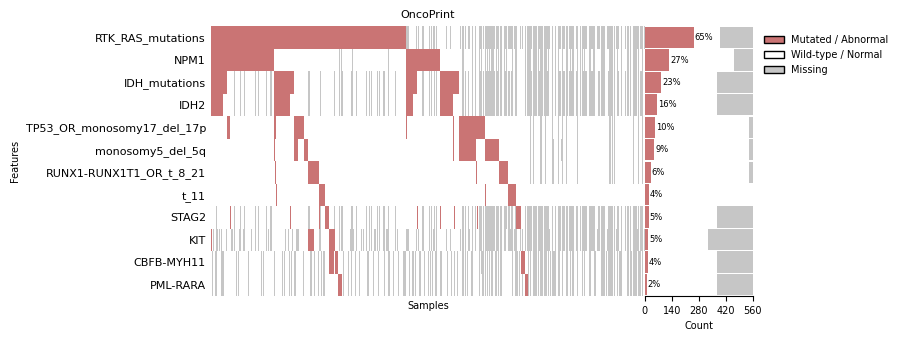

In [67]:
# get subjects with image date available in either BM or PB dataset
subjects_with_image_date = set(df_bm["subject_id"]).union(set(df_pb["subject_id"]))

# read labels (either from BM or PB) and filter to selected subjects
labels = pd.read_excel(LABEL_DATA_PATH_BM)
label_map = json.load(open(LABEL_MAP_PATH_BM, "r"))
labels = get_target_labels(labels, label_map, SELECTED_VARIABLES)
labels = labels[labels["subject_id"].isin(subjects_with_image_date)]

df = labels[SELECTED_VARIABLES].replace({1: 'POS', 0: 'NEG'})

oncoprint(
    df,
    category_colors={"POS": "#CA7474", "NEG": "#FFFFFF"},
    category_names={"POS": "Mutated / Abnormal", "NEG": "Wild-type / Normal", "NaN": "Missing"},
    order_by="POS",
    missing_label="NaN",
    missing_color="#C6C6C6",
    show_percentages="POS",
    figsize=(7, 3.5),
    order_samples=True,
    order_features=True,
    highlight_feature=None,
    highlight_color="tab:red",
    title="OncoPrint",
    xlabel="Samples",
    ylabel="Features",
    fontsize=8,
)
plt.show()

#### B) Cell differentials

In [68]:
import pandas as pd
from typing import Tuple

def compute_cell_counts_and_proportions(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute count and percentage proportion of each cell label per (database_id, album_id).

    Returns two DataFrames:
    - counts: raw counts per cell_label
    - proportions: percentage per cell_label (0-100) with '_Proportion' suffix
    """
    
    # Count occurrences per bag
    counts = (
        df.groupby(["database_id", "album_id", "cell_label"], observed=True)
          .size()
          .unstack(fill_value=0)
          .reset_index()
    )
    
    # Compute proportions (%)
    proportion_cols = [c for c in counts.columns if c not in ["database_id", "album_id"]]
    proportions = counts.copy()
    proportions[proportion_cols] = counts[proportion_cols].div(counts[proportion_cols].sum(axis=1), axis=0).mul(100)
    
    return counts, proportions


In [69]:
adata_bm = ad.read_h5ad(H5AD_DATA_PATH_BM)

df = adata_bm.obs.copy()

df = df[["database_id", "album_id", "cell_label"]]

cell_counts, cell_proportions = compute_cell_counts_and_proportions(df)
cell_proportions.head()


cell_label,database_id,album_id,Basophils,Blasts,Eosinophils,Eosinophils_immature,Erythroblasts,Lymphocytes,Macrophages,Megakaryocytes,Metamyelocytes,Monocytes,Myelocytes,Neutrophils,Plasma_cells,Proerythroblasts,Promonocytes,Promyelocytes
0,VisionDB_2010,290,0.755668,4.511106,0.320586,0.068697,13.166934,6.251431,0.000000,0.068697,0.709869,0.297687,1.213648,1.167850,0.366384,0.824365,0.847264,69.429815
1,VisionDB_2010,292,0.057620,46.211466,0.489772,0.201671,6.251801,31.057332,0.115241,0.144051,0.893114,9.190435,1.382887,2.160761,1.037165,0.230481,0.432152,0.144051
2,VisionDB_2010,293,1.324841,21.248408,4.968153,8.305732,7.286624,1.630573,0.025478,0.662420,3.541401,9.528662,24.585987,9.579618,0.203822,0.484076,6.471338,0.152866
3,VisionDB_2010,299,0.031427,47.360151,0.125707,0.219987,0.722816,2.545569,0.000000,0.031427,2.576996,9.365179,1.288498,2.011314,0.000000,0.031427,33.280955,0.408548
4,VisionDB_2010,303,0.317662,11.340534,0.508259,0.508259,47.681067,9.434562,0.000000,0.285896,2.064803,0.476493,3.335451,4.288437,13.818297,5.019060,0.127065,0.794155


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple

def plot_cell_strip_box(
    df: pd.DataFrame,
    variables: List[str],
    value_name: str = "Cell count",
    color: str = "#672C57",
    figsize: Tuple[float, float] = (4, 2.8),
    fontsize: int = 7,
    xlabel: str = "",
    ylabel: str = "",
    title: str = "",
    xticks: Optional[List[float]] = None,
    xlimit: Optional[Tuple[float, float]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a combined stripplot + boxplot for cell data (counts or proportions).

    Args:
        df: DataFrame with the data to plot (counts or proportions).
        variables: List of variables (column names) to include in the plot.
        value_name: Name for the x-axis values (e.g., 'Cell count' or 'Cell proportion').
        color: Color for the stripplot points.
        figsize: Figure size.
        fontsize: Font size for axis labels.
        xlabel: Label for the x-axis.
        ylabel: Label for the y-axis.
    Returns:
        Figure and Axes objects of the plot.
    """

    # Melt the dataframe for seaborn
    melted_df = pd.melt(df[variables], var_name="Cell type", value_name=value_name)

    # Create figure and axes
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Stripplot
    sns.stripplot(
        y="Cell type",
        x=value_name,
        data=melted_df,
        size=2,
        linewidth=0,
        zorder=0,
        alpha=0.7,
        ax=ax,
        color=color
    )

    # Boxplot
    sns.boxplot(
        y="Cell type",
        x=value_name,
        data=melted_df,
        linewidth=0.8,
        ax=ax,
        showfliers=False,
        whis=0,
        zorder=1,
        boxprops=dict(facecolor="none", edgecolor="black"),
        whiskerprops=dict(color="black", linestyle="--"),
        capprops=dict(color="black", linestyle="--"),
        medianprops=dict(color="black")
    )

    ax.set_xlabel(xlabel, fontsize=fontsize-1)
    ax.set_ylabel(ylabel, fontsize=fontsize-1)
    ax.set_title(title, fontsize=fontsize)

    if xticks is not None:
        ax.set_xticks(xticks)
    ax.tick_params(axis='x', labelsize=fontsize-1)
    ax.tick_params(axis='y', labelsize=fontsize-1)
    if xlimit is not None:
        ax.set_xlim(xlimit)

    ax.spines[['left', 'right', 'top']].set_visible(False)
    ax.tick_params(left=False)

    plt.tight_layout()
    plt.show()


### Bone marrow

In [71]:

adata_bm = ad.read_h5ad(H5AD_DATA_PATH_BM)

df = adata_bm.obs.copy()
df = df[["database_id", "album_id", "cell_label"]]

cell_counts, cell_proportions = compute_cell_counts_and_proportions(df)

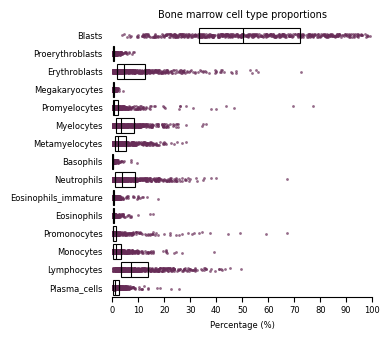

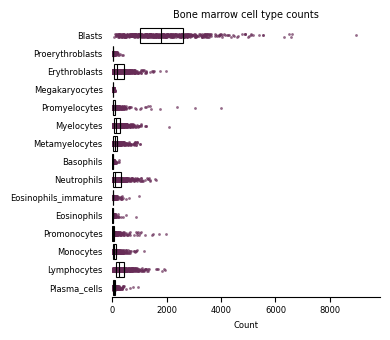

In [72]:
variables_to_include = [v.replace('_proportion', '') for v in CELL_DIFF_VARIABLE_NAMES_BM.keys()]

# Plot proportions
plot_cell_strip_box(
    cell_proportions, 
    variables_to_include,
    figsize=(4, 3.5),
    value_name="Cell proportion", 
    color="#672C57",
    xticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    xlimit=(0, 100),
    xlabel="Percentage (%)",
    title="Bone marrow cell type proportions",
)

# Plot counts
plot_cell_strip_box(
    cell_counts, 
    variables_to_include,
    figsize=(4, 3.5), 
    value_name="Cell count",
    color="#672C57",
    xlabel="Count",
    xlimit=(0, max(cell_counts[variables_to_include].max()) * 1.1,),
    title="Bone marrow cell type counts",
)

### Peripheral blood

In [73]:

adata_pb = ad.read_h5ad(H5AD_DATA_PATH_PB)

df = adata_pb.obs.copy()
df = df[["database_id", "album_id", "cell_label"]]

cell_counts, cell_proportions = compute_cell_counts_and_proportions(df)

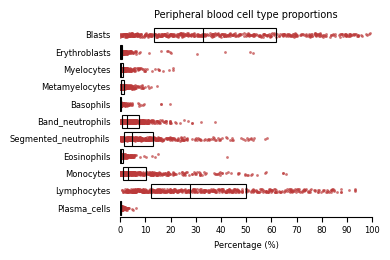

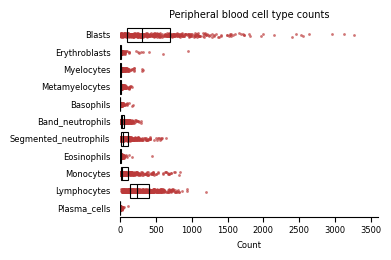

In [74]:
variables_to_include = [v.replace('_proportion', '') for v in CELL_DIFF_VARIABLE_NAMES_PB.keys()]

# Plot proportions
plot_cell_strip_box(
    cell_proportions, 
    variables_to_include,
    figsize=(4, 2.7), 
    value_name="Cell proportion", 
    color="#BB3A3A",
    xticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    xlimit=(0, 100),
    xlabel="Percentage (%)",
    title="Peripheral blood cell type proportions",
)   

# Plot counts
plot_cell_strip_box(
    cell_counts, 
    variables_to_include, 
    figsize=(4, 2.7), 
    value_name="Cell count",
    color="#BB3A3A",
    xlabel="Count",
    xlimit=(0, max(cell_counts[variables_to_include].max()) * 1.1,),
    title="Peripheral blood cell type counts",
)

# **Figure 3 - Model results**

### Bone marrow

#### A) AUROC

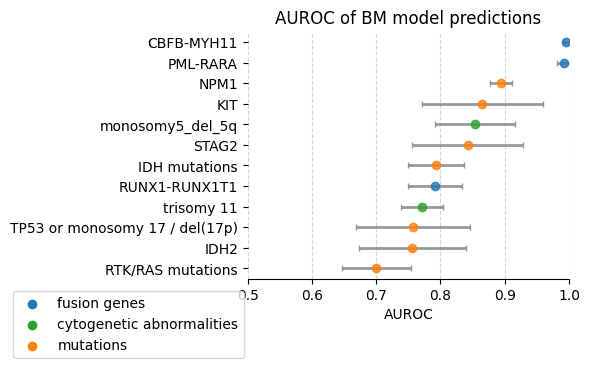

In [75]:
pr_auc = collect_performance_metrics(MODEL_RESULTS_PATH_BM, "pr_auc")
roc_auc = collect_performance_metrics(MODEL_RESULTS_PATH_BM, "roc_auc")
results = pd.merge(pr_auc, roc_auc, on=["variable", "group"], how="inner", suffixes=("", "_roc_auc"))
results = results[results["variable"].isin(SELECTED_VARIABLES)]

# Merge metric and attention data
#df = pd.merge(results, df_attention, on=["variable", "group"], how="inner")

# sort by metric mean
results = results.sort_values(f"roc_auc_mean", ascending=True)

plot_metric_errorbars(
    results, 
    "roc_auc",
    fig_height_per_row=0.3,
    fig_width=6, 
    title="AUROC of BM model predictions",
    legend_title=None,
    legend_loc = "lower right",
    legend_bbox = (0.01, -0.35),
    x_limit=(0.5, 1),
    x_label="AUROC",
    disable_sorting=True,
)

#### B) PR-AUC

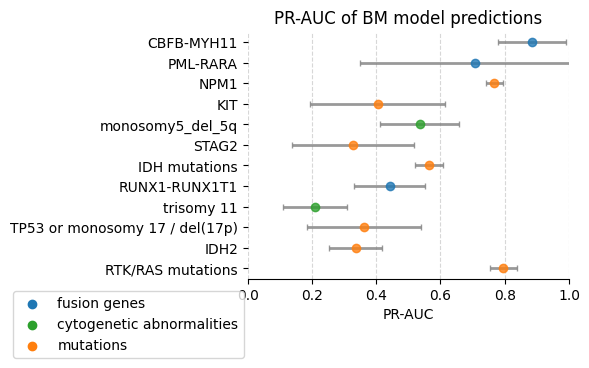

In [76]:
plot_metric_errorbars(
    results, 
    "pr_auc",
    fig_height_per_row=0.3,
    fig_width=6, 
    title="PR-AUC of BM model predictions",
    legend_title=None,
    legend_loc = "lower right",
    legend_bbox = (0.01, -0.35),
    x_limit=(0, 1),
    x_label="PR-AUC",
    disable_sorting=True,
)


### Peripheral blood

#### C) AUROC

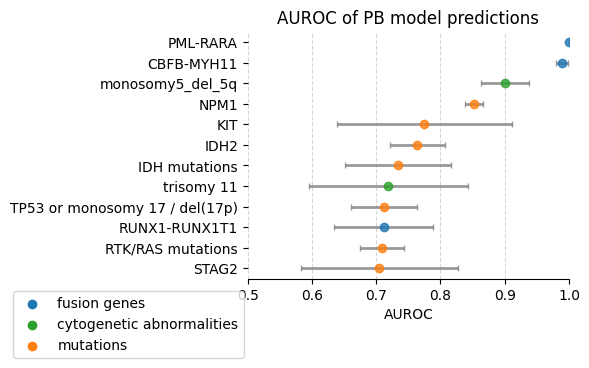

In [77]:
pr_auc = collect_performance_metrics(MODEL_RESULTS_PATH_PB, "pr_auc")
roc_auc = collect_performance_metrics(MODEL_RESULTS_PATH_PB, "roc_auc")
results = pd.merge(pr_auc, roc_auc, on=["variable", "group"], how="inner", suffixes=("", "_roc_auc"))
results = results[results["variable"].isin(SELECTED_VARIABLES)]

# Merge metric and attention data
#df = pd.merge(results, df_attention, on=["variable", "group"], how="inner")

# sort by metric mean
results = results.sort_values(f"roc_auc_mean", ascending=True)

plot_metric_errorbars(
    results, 
    "roc_auc",
    fig_height_per_row=0.3,
    fig_width=6, 
    title="AUROC of PB model predictions",
    legend_title=None,
    legend_loc = "lower right",
    legend_bbox = (0.01, -0.35),
    x_limit=(0.5, 1),
    x_label="AUROC",
    disable_sorting=True,
)


#### D) PR-AUC

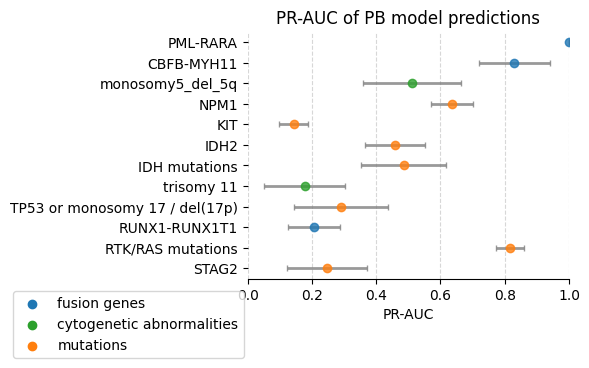

In [78]:
plot_metric_errorbars(
    results, 
    "pr_auc",
    fig_height_per_row=0.3,
    fig_width=6, 
    title="PR-AUC of PB model predictions",
    legend_title=None,
    legend_loc = "lower right",
    legend_bbox = (0.01, -0.35),
    x_limit=(0, 1),
    x_label="PR-AUC",
    disable_sorting=True,
)

# **Figure 5 - Analysis of sample-level fingerprint**

## **Cell differentials**

### Bone marrow

> Observed mutations and aberrations:

#### A)

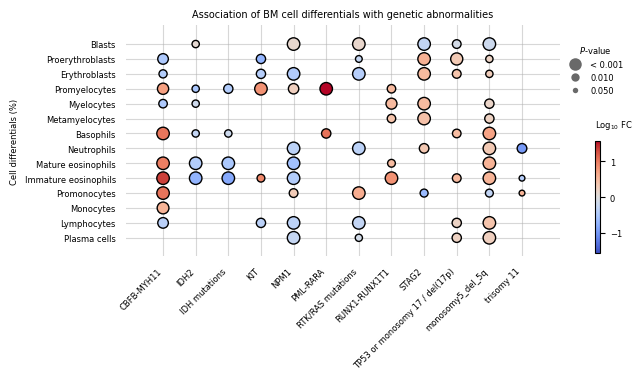

In [79]:
temp = sort_features(get_bm_cell_differential_variables(), CELL_LINEAGE_ORDER_BM, CELL_STATISTIC_ORDER)

cell_differential_stats, _ = plot_balloon_plot(
    df=df_bm,
    cat_vars={variable: get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: CELL_DIFF_VARIABLE_NAMES_BM[variable] for variable in temp}, #sort_features_by_lineage(get_bm_cell_differential_variables(), CELL_LINEAGE_ORDER_BM)
    max_pvalue=0.05,
    adjust_p_values=True,
    plot_height=3,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=8,
    save_path="figures/balloon_plot_bm_cell_differentials.png",
    title="Association of BM cell differentials with genetic abnormalities",
    ylabel="Cell differentials (%)",
)

#cell_differential_stats.head()

> Predicted mutations and aberrations:

#### Supplement

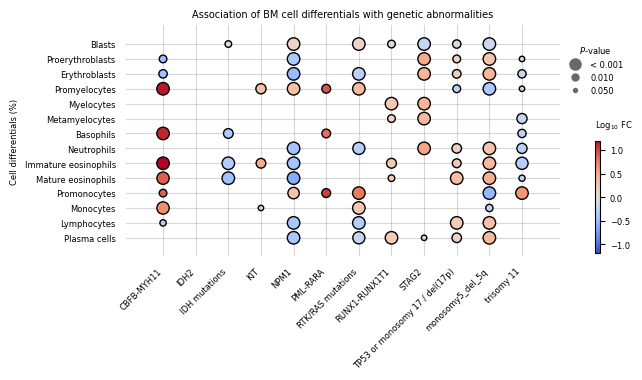

In [80]:
cell_differential_stats, _ = plot_balloon_plot(
    df=df_bm,
    cat_vars={f"{variable}_predicted": get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: CELL_DIFF_VARIABLE_NAMES_BM[variable] for variable in sort_features_by_lineage(get_bm_cell_differential_variables(), CELL_LINEAGE_ORDER_BM)},
    max_pvalue=0.05,
    adjust_p_values=True,
    plot_height=3,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=8,
    save_path="figures/balloon_plot_bm_cell_differentials.png",
    title="Association of BM cell differentials with genetic abnormalities",
    ylabel="Cell differentials (%)",
)

#cell_differential_stats.head()

### Peripheral blood

> Observed mutations and aberrations:

#### B)

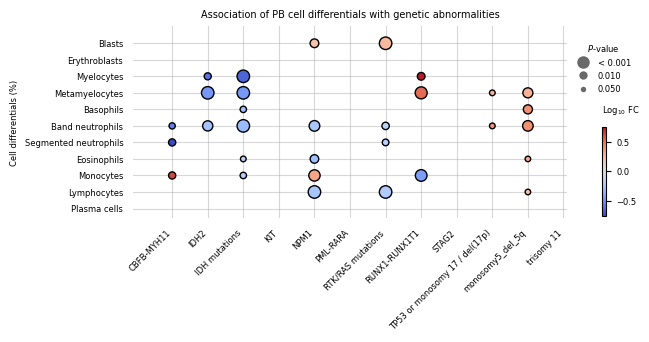

In [81]:
cell_differential_stats, _ = plot_balloon_plot(
    df=df_pb,
    cat_vars={variable: get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: CELL_DIFF_VARIABLE_NAMES_PB[variable] for variable in sort_features_by_lineage(get_pb_cell_differential_variables(), CELL_LINEAGE_ORDER_PB)},
    max_pvalue=0.05,
    adjust_p_values=True,
    plot_height=2.5,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=7,
    save_path="figures/balloon_plot_pb_cell_differentials.png",
    title="Association of PB cell differentials with genetic abnormalities",
    ylabel="Cell differentials (%)",
)

#cell_differential_stats.head()

> Predicted mutations and aberrations:

#### Supplement

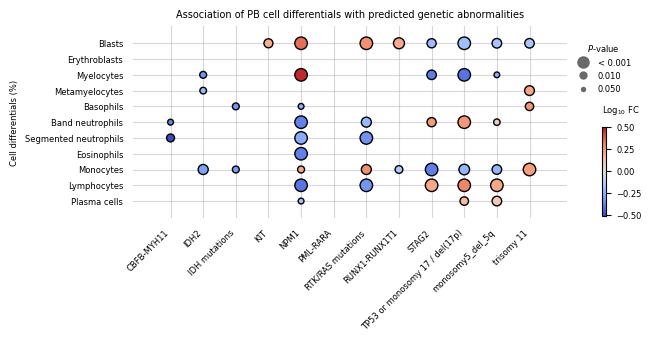

In [82]:
cell_differential_stats, _ = plot_balloon_plot(
    df=df_pb,
    cat_vars={f"{variable}_predicted": get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: CELL_DIFF_VARIABLE_NAMES_PB[variable] for variable in sort_features_by_lineage(get_pb_cell_differential_variables(), CELL_LINEAGE_ORDER_PB)},
    max_pvalue=0.05,
    adjust_p_values=True,
    plot_height=2.5,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=7,
    save_path="figures/balloon_plot_pb_cell_differentials_predicted.png",
    title="Association of PB cell differentials with predicted genetic abnormalities",
    ylabel="Cell differentials (%)",
)

#cell_differential_stats.head()

## **Analysis of cell statistics**

### Bone marrow

> Observed mutations and aberrations:

#### Supplement

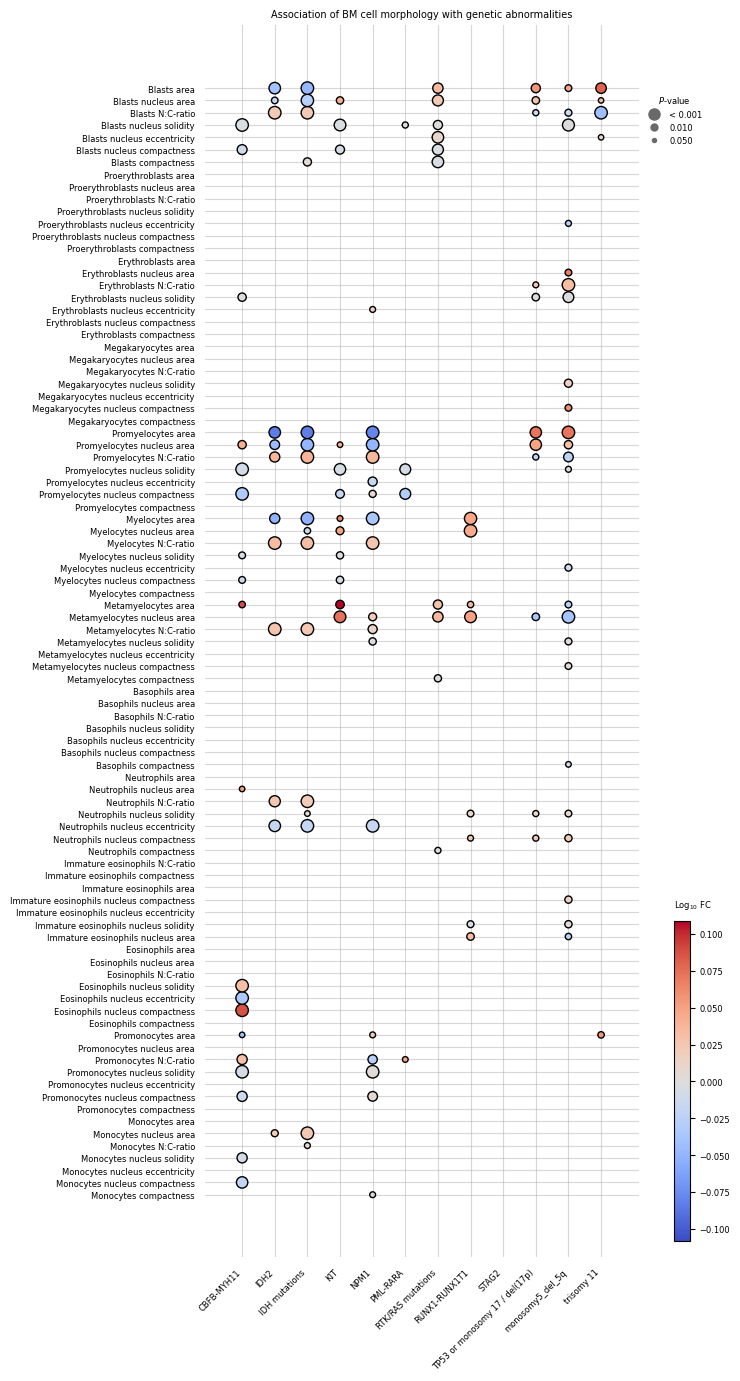

In [83]:
cell_statistic_variables_ordered = sort_features(cell_statistic_variables_bm, CELL_LINEAGE_ORDER_BM, CELL_STATISTIC_ORDER)

cell_statistic_stats, balloon_plot_data = plot_balloon_plot(
    df=df_bm,
    cat_vars={variable: get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: get_human_readable_cell_statistic_variable(variable) for variable in cell_statistic_variables_ordered},
    max_pvalue=0.05,
    plot_height=16,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=80,
    save_path="figures/balloon_plot_bm_cell_statistics.png",
    title="Association of BM cell morphology with genetic abnormalities",
)

#cell_statistic_stats.head()

#### C)

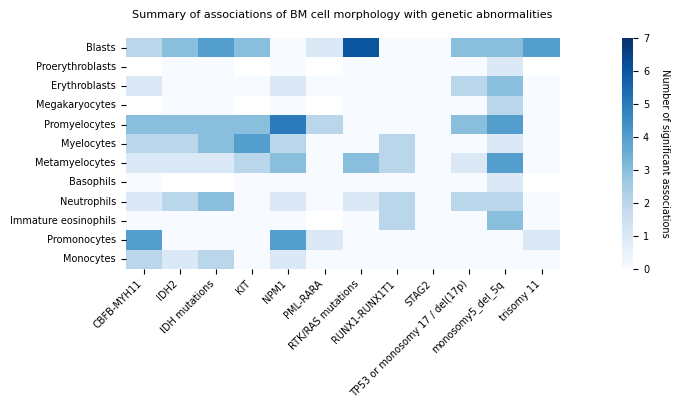

In [84]:
# Create matrix
matrix = create_cell_statistic_summary_matrix(
    df=balloon_plot_data,
    cell_types=list(CELL_DIFF_VARIABLE_NAMES_BM.values()),
    variable_order=SELECTED_VARIABLES,
    readable_variable_func=get_readable_variable_name,
    max_p_value=0.05,
)

# Plot heatmap
ax = plot_cell_statistic_summary(
    matrix=matrix,
    figsize=(7, 3),
    font_size=8,
    cbar_shrink=1,
    vmin=0,
    vmax=7,
    title="Summary of associations of BM cell morphology with genetic abnormalities\n",
)

> Predicted mutations and aberrations:

#### Supplement

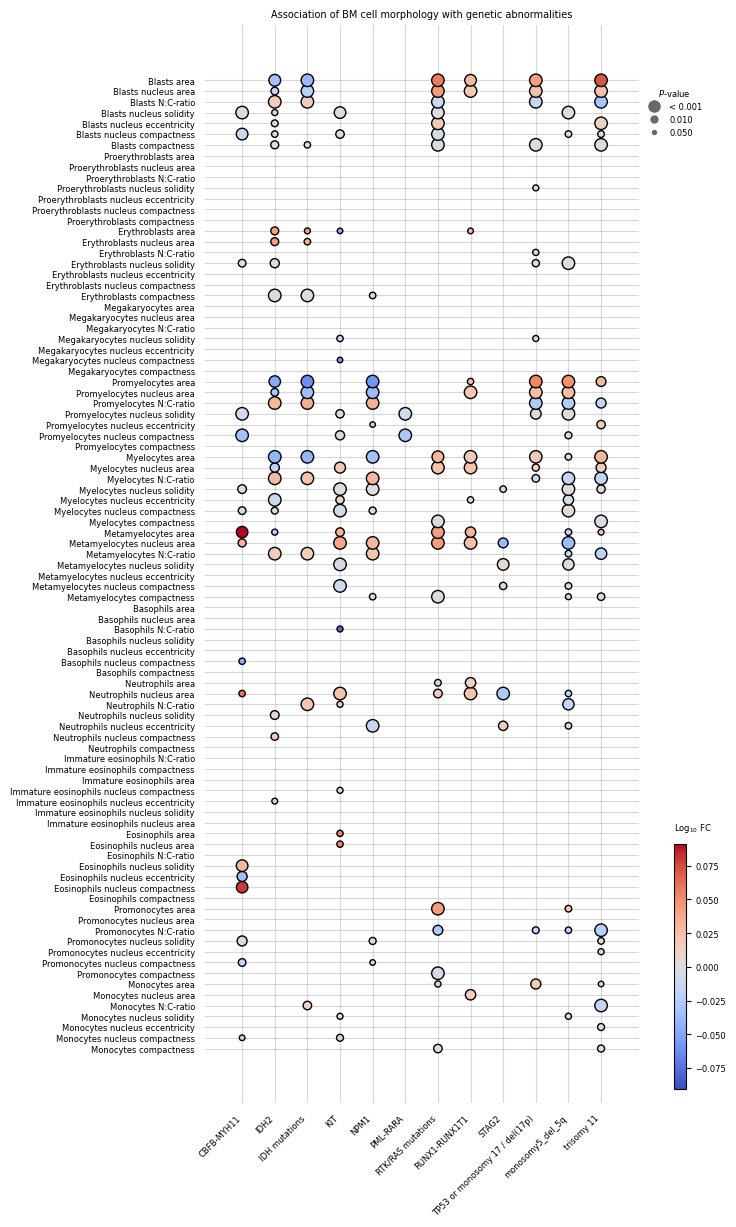

In [85]:
cell_statistic_variables_ordered = sort_features(cell_statistic_variables_bm, CELL_LINEAGE_ORDER_BM, CELL_STATISTIC_ORDER)

cell_statistic_stats, balloon_plot_data = plot_balloon_plot(
    df=df_bm,
    cat_vars={f"{variable}_predicted": get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: get_human_readable_cell_statistic_variable(variable) for variable in cell_statistic_variables_ordered},
    max_pvalue=0.05,
    plot_height=14,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=80,
    save_path="figures/balloon_plot_bm_cell_statistics.png",
    title="Association of BM cell morphology with genetic abnormalities",
)

#cell_statistic_stats.head()

#### Supplement

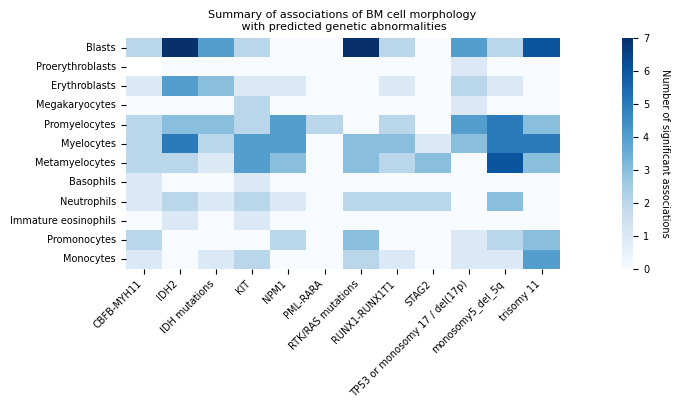

In [86]:
matrix = create_cell_statistic_summary_matrix(
    df=balloon_plot_data,
    cell_types=list(CELL_DIFF_VARIABLE_NAMES_BM.values()),
    variable_order=SELECTED_VARIABLES,
    readable_variable_func=get_readable_variable_name,
    max_p_value=0.05,
)
ax = plot_cell_statistic_summary(
    matrix=matrix,
    figsize=(7, 3),
    font_size=8,
    cbar_shrink=1,
    vmin=0,
    vmax=7,
    title="Summary of associations of BM cell morphology\n with predicted genetic abnormalities",
)

### Peripheral blood

> Observed mutations and aberrations:

#### Supplement

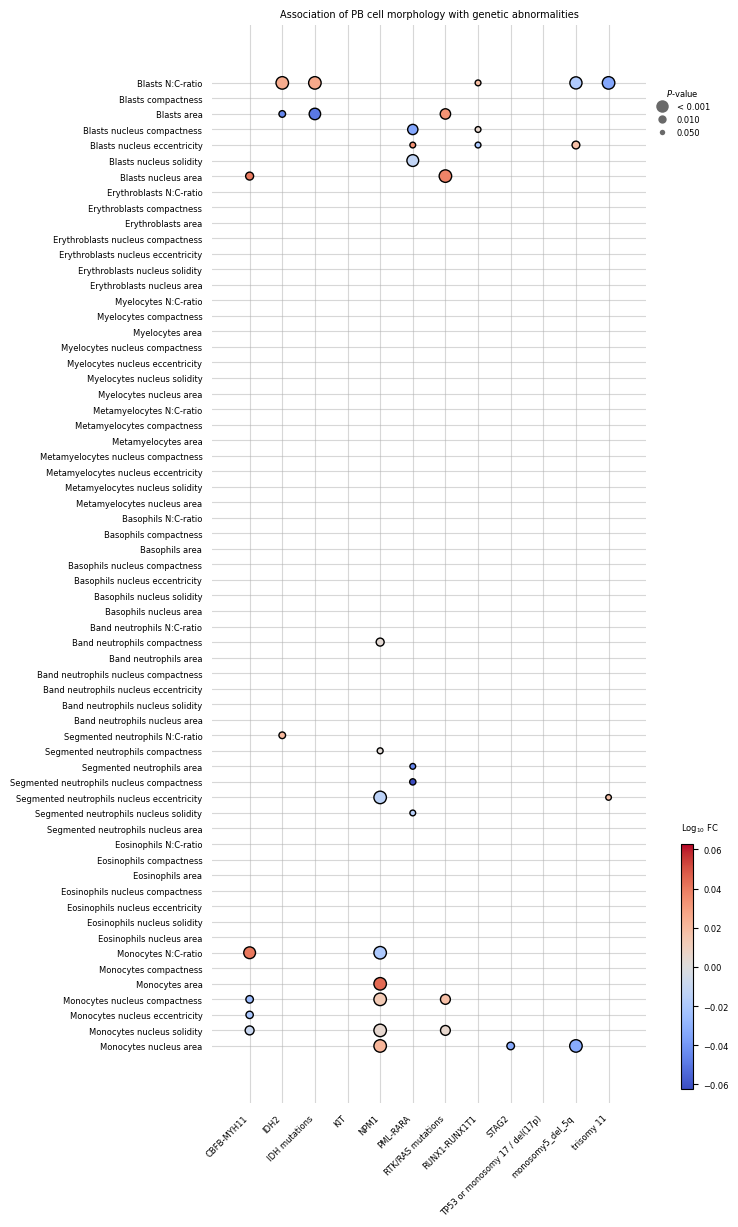

In [87]:
cell_statistic_variables_ordered = sort_features_by_lineage(cell_statistic_variables_pb, CELL_LINEAGE_ORDER_PB)

cell_statistic_stats, balloon_plot_data = plot_balloon_plot(
    df=df_pb,
    cat_vars={variable: get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: get_human_readable_cell_statistic_variable(variable) for variable in cell_statistic_variables_ordered},
    max_pvalue=0.05,
    adjust_p_values=True,
    plot_height=14,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=80,
    save_path="figures/balloon_plot_pb_cell_statistics.png",
    title="Association of PB cell morphology with genetic abnormalities",
)

#cell_statistic_stats.head()

#### D)

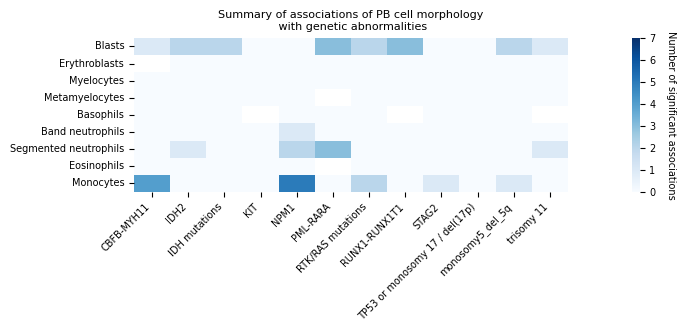

In [88]:
# Create matrix
matrix = create_cell_statistic_summary_matrix(
    df=balloon_plot_data,
    cell_types=list(CELL_DIFF_VARIABLE_NAMES_PB.values()),
    variable_order=SELECTED_VARIABLES,
    readable_variable_func=get_readable_variable_name,
    max_p_value=0.05,
)

# Plot heatmap
ax = plot_cell_statistic_summary(
    matrix=matrix,
    figsize=(7, 2),
    font_size=8,
    cbar_shrink=1,
    vmin=0,
    vmax=7,
    title="Summary of associations of PB cell morphology\n with genetic abnormalities",
)

> Predicted mutations and aberrations:

#### Supplement

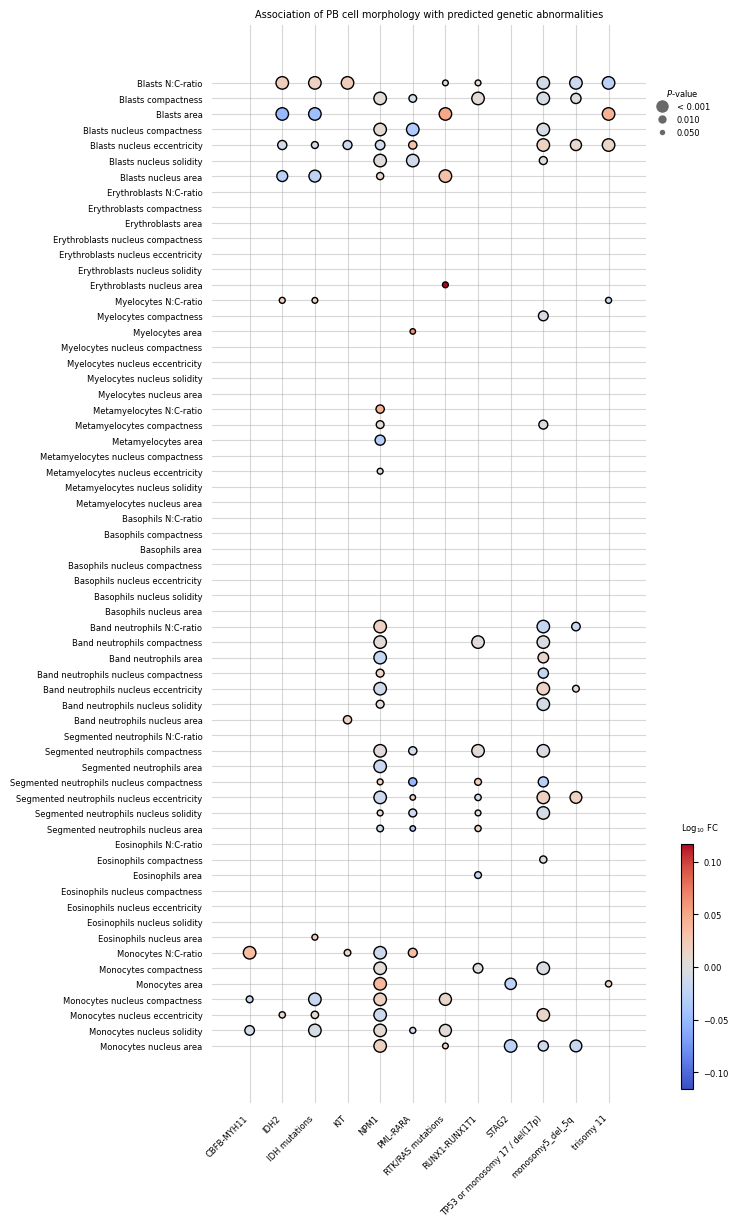

In [89]:
cell_statistic_variables_ordered = sort_features_by_lineage(cell_statistic_variables_pb, CELL_LINEAGE_ORDER_PB)

cell_statistic_stats, balloon_plot_data = plot_balloon_plot(
    df=df_pb,
    cat_vars={f"{variable}_predicted": get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: get_human_readable_cell_statistic_variable(variable) for variable in cell_statistic_variables_ordered},
    max_pvalue=0.05,
    adjust_p_values=True,
    plot_height=14,
    plot_width=7,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=80,
    save_path="figures/balloon_plot_pb_cell_statistics_predicted.png",
    title="Association of PB cell morphology with predicted genetic abnormalities",
)

#cell_statistic_stats.head()

#### Supplement

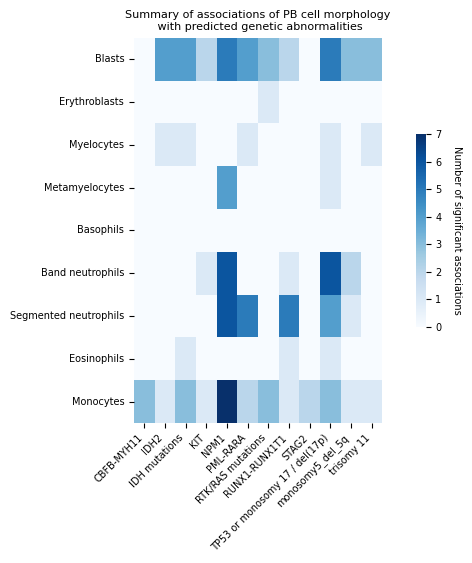

In [90]:
# Create matrix
matrix = create_cell_statistic_summary_matrix(
    df=balloon_plot_data,
    cell_types=list(CELL_DIFF_VARIABLE_NAMES_PB.values()),
    variable_order=SELECTED_VARIABLES,
    readable_variable_func=get_readable_variable_name,
    max_p_value=0.05,
)

# Plot heatmap
ax = plot_cell_statistic_summary(
    matrix=matrix,
    figsize=(4, 5),
    font_size=8,
    cbar_shrink=0.5,
    vmin=0,
    vmax=7,
    title="Summary of associations of PB cell morphology\n with predicted genetic abnormalities",
)

## **Analysis of dysplasia**

### Bone marrow

> Observed mutations and aberrations:

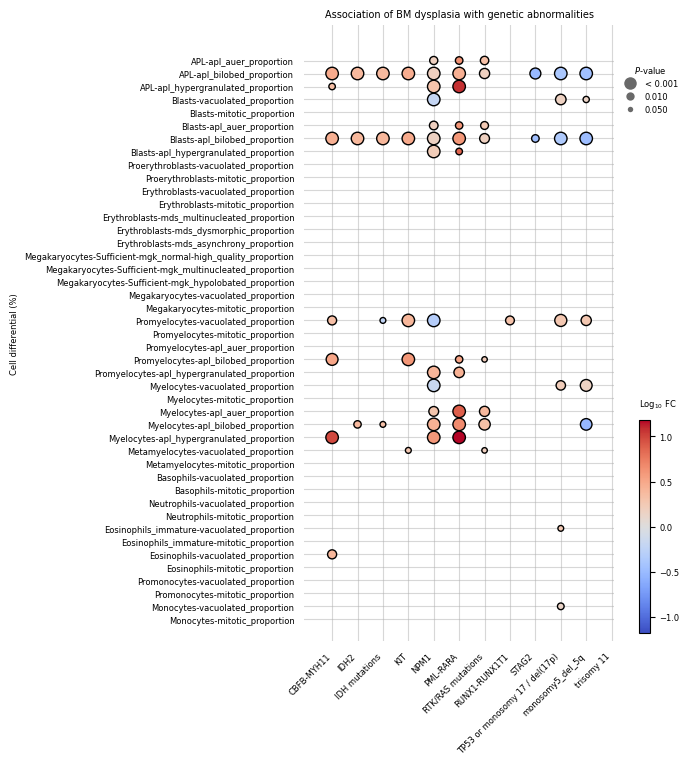

In [91]:
dysplasia_stats = plot_balloon_plot(
    df=df_bm,
    cat_vars={variable: get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: variable for variable in sort_features_by_lineage(cell_dysplasia_variables_bm, CELL_LINEAGE_ORDER_BM)},
    max_pvalue=0.05,
    plot_height=8,
    plot_width=5,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=30,
    save_path="figures/balloon_plot_bm_cell_dysplasia.png",
    title="Association of BM dysplasia with genetic abnormalities",
    ylabel="Cell differential (%)",
)

#dysplasia_stats.head()

In [92]:
#df_bm.filter(regex="mgk")

> Predicted mutations and aberrations:

### Peripheral blood

> Observed mutations and aberrations:

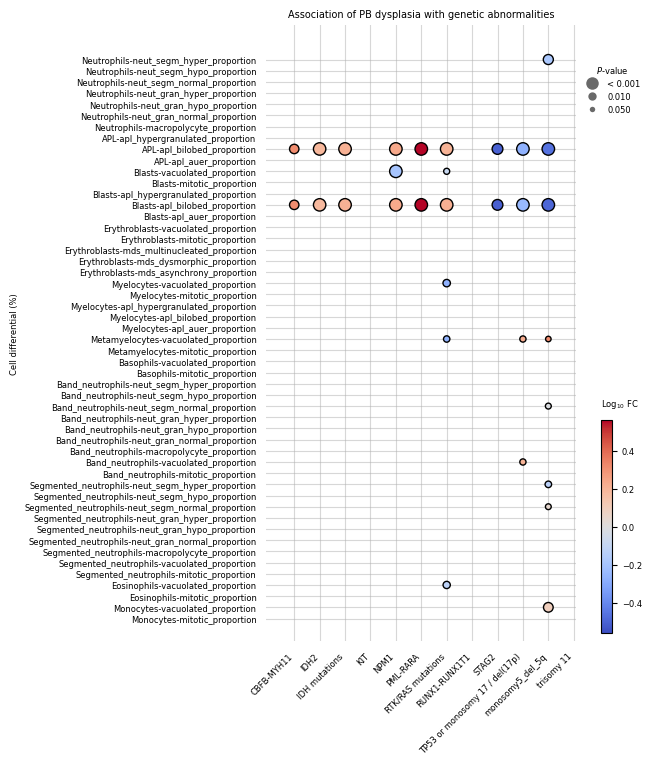

In [93]:
dysplasia_stats = plot_balloon_plot(
    df=df_pb,
    cat_vars={variable: get_readable_variable_name(variable) for variable in SELECTED_VARIABLES},
    cont_vars={variable: variable for variable in sort_features_by_lineage(cell_dysplasia_variables_pb, CELL_LINEAGE_ORDER_PB)},
    max_pvalue=0.05,
    adjust_p_values=True,
    plot_height=8,
    plot_width=5,
    fontsize=7,
    scale_factor=3,
    swap_axes=True,
    sort_by_pvalue=False,
    cbar_divider=30,
    save_path="figures/balloon_plot_pb_cell_dysplasia.png",
    title="Association of PB dysplasia with genetic abnormalities",
    ylabel="Cell differential (%)",
)

#dysplasia_stats.head()

> Predicted mutations and aberrations:

# **Supplementary Figure 3 - Model error analysis**

## **i) Oncorpint of false positives**

### Bone marrow

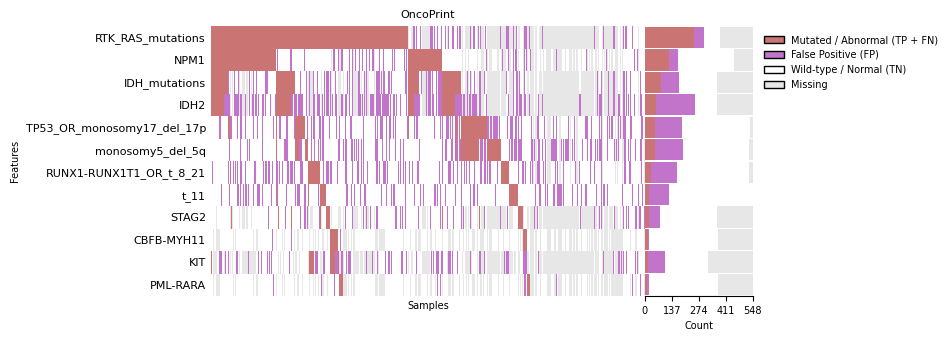

In [94]:
df = build_oncoprint_data_from_predictions(df_bm, pred_suffix="_predicted", mode="POS_FP_TN", pos_label=1, neg_label=0)

oncoprint(
    df,
    category_colors={
        "POS": "#CA7474",
        "FP": "#C174CA",
        "TN": "#ffffff",
    },
    category_names={
        "POS": "Mutated / Abnormal (TP + FN)",
        "FP": "False Positive (FP)",
        "TN": "Wild-type / Normal (TN)",
        "NaN": "Missing",
    },
    order_by="POS",
    missing_label="NaN",
    missing_color="#E7E7E7",
    figsize=(7, 3.5),
    order_samples=True,
    order_features=True,
    highlight_feature=None,
    highlight_color="tab:red",
    title="OncoPrint",
    xlabel="Samples",
    ylabel="Features",
    fontsize=8,
)
plt.show()

### Peripheral blood

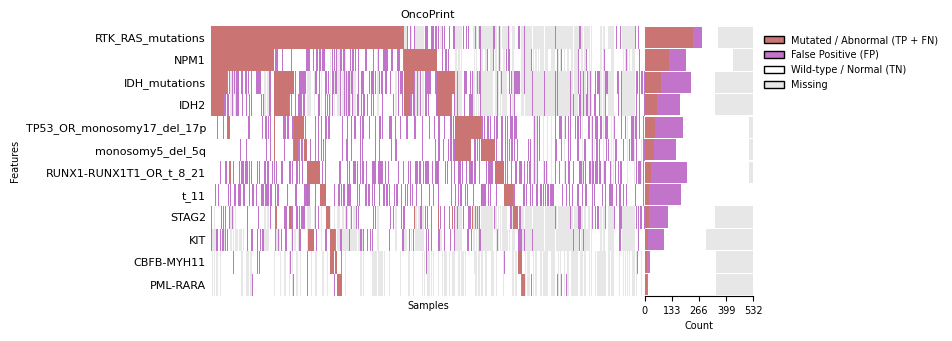

In [95]:
df = build_oncoprint_data_from_predictions(df_pb, pred_suffix="_predicted", mode="POS_FP_TN", pos_label=1, neg_label=0)

oncoprint(
    df,
    category_colors={
        "POS": "#CA7474",
        "FP": "#C174CA",
        "TN": "#ffffff",
    },
    category_names={
        "POS": "Mutated / Abnormal (TP + FN)",
        "FP": "False Positive (FP)",
        "TN": "Wild-type / Normal (TN)",
        "NaN": "Missing",
    },
    order_by="POS",
    missing_label="NaN",
    missing_color="#E7E7E7",
    figsize=(7, 3.5),
    order_samples=True,
    order_features=True,
    highlight_feature=None,
    highlight_color="tab:red",
    title="OncoPrint",
    xlabel="Samples",
    ylabel="Features",
    fontsize=8,
)
plt.show()

## **i) Oncorpint of false negatives**

### Bone marrow

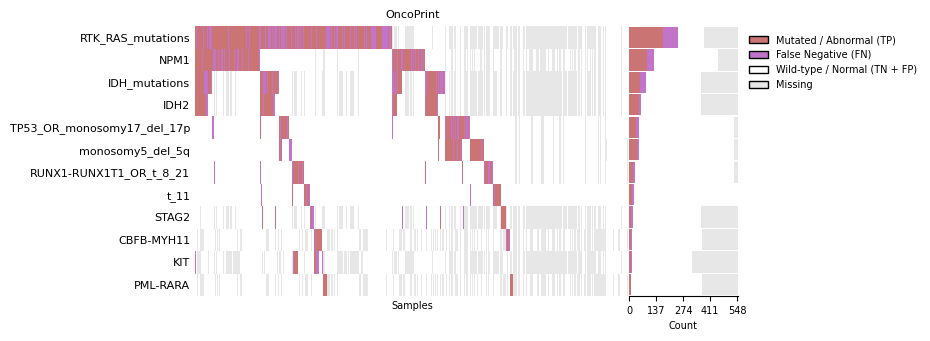

In [96]:
df = build_oncoprint_data_from_predictions(df_bm, pred_suffix="_predicted", mode="TP_FN_NEG", pos_label=1, neg_label=0)

oncoprint(
    df,
    category_colors={
        "TP": "#CA7474",
        "FN": "#C174CA",
        "NEG": "#ffffff",
    },
    category_names={
        "TP": "Mutated / Abnormal (TP)",
        "FN": "False Negative (FN)",
        "NEG": "Wild-type / Normal (TN + FP)",
        "NaN": "Missing",
    },
    order_by=["TP", "FN"],
    missing_label="NaN",
    missing_color="#E7E7E7",
    figsize=(7, 3.5),
    order_samples=True,
    order_features=True,
    highlight_feature=None,
    highlight_color="tab:red",
    title="OncoPrint",
    xlabel="Samples",
    ylabel="",
    fontsize=8,
)
plt.show()

### Peripheral blood

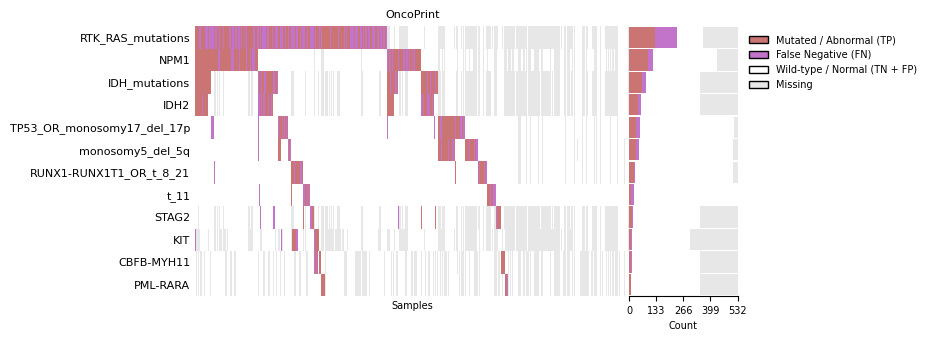

In [97]:
df = build_oncoprint_data_from_predictions(df_pb, pred_suffix="_predicted", mode="TP_FN_NEG", pos_label=1, neg_label=0)

oncoprint(
    df,
    category_colors={
        "TP": "#CA7474",
        "FN": "#C174CA",
        "NEG": "#ffffff",
    },
    category_names={
        "TP": "Mutated / Abnormal (TP)",
        "FN": "False Negative (FN)",
        "NEG": "Wild-type / Normal (TN + FP)",
        "NaN": "Missing",
    },
    order_by=["TP", "FN"],
    missing_label="NaN",
    missing_color="#E7E7E7",
    figsize=(7, 3.5),
    order_samples=True,
    order_features=True,
    highlight_feature=None,
    highlight_color="tab:red",
    title="OncoPrint",
    xlabel="Samples",
    ylabel="",
    fontsize=8,
)
plt.show()